# Content

[1. Setup](#Setup)

[2. Data Cleaning and Preparation](#Data-Cleaning-&-Preparation)

# Setup¶

In [ ]:
#import basic system functions
import os
import datetime
from collections import Counter

#import libraries for data wrangling
import pandas as pd
import numpy as np

#import libraries for plotting data
import matplotlib.pyplot as plt
import matplotlib.pyplot as mplt

%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.plotting import autocorrelation_plot, lag_plot
from scipy import signal
# If you want a style choose one
#plt.style.use('Solarize_Light2')
#plt.style.use('tableau-colorblind10')
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'



#import libraries for time series analysis
from fbprophet import Prophet
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing

#import libraries for statistics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')


from IPython.display import Image
from datetime import datetime
import holidays

In [ ]:
 df= pd.read_csv("/Users/brittarover/Capstone/Meteolytics/meteolytix_Artikelgruppen_Umsatz_verschiedeneStandorte.csv")

In [ ]:
df.head()

In [ ]:
df.shape

### Modify Dataframe to define the labels as columns


**Conclusions**
- `To analyse the single labels, the different articlegroups, the dataframe needs to be restructured by using a pivot table. The result is a dataframe with one single column per articlegroup which can be used for prediction.`
- `To consider the different closed days for the filialen / stores i do it in a second step separatly for the stores.`

In [ ]:
df_new=pd.pivot_table(df, values='Umsatz', index=['Datum','Filiale'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0).reset_index()

In [ ]:
#create empty dataframe with 'complete' datetime index
date_df = pd.DataFrame(index=pd.date_range(start='1/1/2015', end=df.Datum.max()))
df_new_1 = pd.pivot_table(df[df.Filiale == 1], values='Umsatz', index=['Datum'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0)
#fill missing days due to store closings with 0 
df_new_1=df_new_1.merge(date_df, how='right', left_index= True,right_index=True).fillna(0)
df_new_1.index = df_new_1.index.set_names(['Datum'])
df_new_1=df_new_1.reset_index()

df_new_2 = pd.pivot_table(df[df.Filiale == 2], values='Umsatz', index=['Datum'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0)
#fill missing days due to store closings with 0 
df_new_2 = df_new_2.merge(date_df, how='right',left_index= True,right_index=True).fillna(0)
df_new_2.index = df_new_2.index.set_names(['Datum'])
df_new_2=df_new_2.reset_index()

df_new_3 = pd.pivot_table(df[df.Filiale == 3], values='Umsatz', index=['Datum'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0)
#fill missing days due to store closings with 0 
df_new_3 = df_new_3.merge(date_df, how='right',left_index= True,right_index=True).fillna(0)
df_new_3.index = df_new_3.index.set_names(['Datum'])
df_new_3=df_new_3.reset_index()

### Adding Warengruppeninfo

**Conclusions**
- `I introduce Warengruppen given by meterolytics to give an better overall picture to the sales trends.`

In [ ]:
# Adding Warenguppeninfo
df['Warengruppe']=df['Artikelgruppe'].apply(lambda x: "Brot" if x in (1,2,3,4,5) else "Brötchen" if x in (6,7) 
                                            else "Spezial_Brötchen" if x==8 else
                                              "Konditorei" if x in (9,10) else "Kuchen" if x in (11,12) else "Weihnachtsartikel") 

In [ ]:
df_new_waren = pd.pivot_table(df, values='Umsatz', index=['Datum','Filiale'],
                    columns=['Warengruppe'], aggfunc=np.sum, fill_value=0).reset_index()

In [ ]:
# Renaming Artikelgruppe for all new dataframes
liste=[df_new,df_new_1,df_new_2,df_new_3,df_new_waren]

for i in liste:
  i.rename(columns={1:'Weizenbrot',2:"Mischbrot",3:'Vollkornbrot',4:"Stangenbrote",5:"Spezialbrot",6 : "Brötchen",
                       7 : "Süsse_Brötchen",8 :"Herzhafte_Brötchen",9 : "KonditoreiBlech1",10: "KonditoreiBlech2",
                       11: "Stückgebäck", 12:"Blechkuchen",13 : "Weihnachtsartikel"
                          }, 
                 inplace=True)

In [ ]:
df_new_1.head().T

### Adding a Gesamt Column

In [ ]:
#Adding a Gesamt column to all the new dataframes which contains the total sales
liste=[df_new,df_new_1,df_new_2,df_new_3]

for i in liste:
    i['Gesamt']=i['Vollkornbrot']+i['Mischbrot']+i['Stangenbrote']+i['Weizenbrot']+i['Spezialbrot']+i['Brötchen']
    +i['Süsse_Brötchen']+i['Herzhafte_Brötchen']+i['KonditoreiBlech1']+i['KonditoreiBlech2']+i['Blechkuchen']
    +i['Weihnachtsartikel']+i['Stückgebäck']


### Columns Definition

- **Filiale** - There are three different filial stores which are analyzed, one direct in the city (filiale=1), one near the water front (filiale=2) and the third in a residential area (filiale=3)
1 = city; 2 = waterfront area; 3 = city disctrict
- **Datum** - date of the sales data. The period 
- **Warengruppe** - main article group
1 = Brot; 2 = Brötchen; 3 = Spezial_Brötchen; 4 = Konditorei; 5 = Kuchen; 6 = Weihnachtsartikel    
- **Artikelgruppe** - article group
1 = Weizenbrot; 2 = Mischbrot; 3 = Vollkornbrot; 4 = Spezialbrot; 5 = Stangenbrote; 6 = Brötchen; 7 = Süße Brötchen; 8 = Herzhafte Brötchen; 9 = KonditoreiBlech1; 10 = KonditoreiBlech2; 11 = Stückgebäck; 12 = Blechkuchen; 13 = Weiohnachtsartikel;     
- **Umsatz** - Sales volumne per day and article group   

# Data Cleaning & Preparation

### Transformation to Datetime

In [ ]:
# Transformation to Datetime
liste=[df,df_new,df_new_1,df_new_2,df_new_3,df_new_waren]

for i in liste:
  i['Datum'] = pd.to_datetime(i['Datum'])


### Additional Date columns

In [ ]:
for i in liste:
   i['Wochentag']=i['Datum'].dt.weekday
   i['Jahr']=i['Datum'].dt.year
   i['Monat']=i['Datum'].dt.month
   i['Wochenende']=i['Wochentag'].apply(lambda x: 'Wochentag' if x in (0,1,2,3,4) else 'Wochenende')
    

# First Conclusions

## On Total level

**Conclusions**
- `There are a lot of stronger correlations between the Filiale and the single Artikelgruppen.`
- `There are also a lot of stronger correlations between the Artikelgruppen itself.`

In [ ]:
#First we create a new DataFrame with only numerical features
numerics = ['int64', 'float64']

num_df = df_new.select_dtypes(include=numerics)

In [ ]:
#Korrelationsanalyse
mask = np.triu( num_df.corr())
plt.figure(figsize=(13,8))
plt.title('Correlation of variables')
ax=sns.heatmap(num_df.corr(),vmax=1.0,annot=True,mask=mask,cmap='coolwarm')
plt.savefig('correlogram_simple.png')
ax.set_ylim((0,18))
plt.show

## On Filiale level

In [ ]:
numerics = ['int64', 'float64']
num_Filiale_1 = df_new_1.select_dtypes(include=numerics)
num_Filiale_2 = df_new_2.select_dtypes(include=numerics)
num_Filiale_3 = df_new_1.select_dtypes(include=numerics)

In [ ]:
#Korrelationsanalyse FILIALE 1
mask = np.triu(num_Filiale_1.corr())
plt.figure(figsize=(13,8))
plt.title('Correlation of variables')
ax=sns.heatmap(num_Filiale_1.corr(),vmax=1.0,annot=True,mask=mask,cmap='coolwarm')
plt.savefig('correlogram_simple.png')
ax.set_ylim((0,18))
plt.show

In [ ]:
#Korrelationsanalyse FILIALE 2
mask = np.triu( num_Filiale_2.corr())
plt.figure(figsize=(13,8))
plt.title('Correlation of variables')
ax=sns.heatmap(num_Filiale_2.corr(),vmax=1.0,annot=True,mask=mask,cmap='coolwarm')
plt.savefig('correlogram_simple.png')
ax.set_ylim((0,18))
plt.show

In [ ]:
#Korrelationsanalyse FILIALE 3
mask = np.triu( num_Filiale_3.corr())
plt.figure(figsize=(13,8))
plt.title('Correlation of variables')
ax=sns.heatmap(num_Filiale_3.corr(),vmax=1.0,annot=True,mask=mask,cmap='coolwarm')
plt.savefig('correlogram_simple.png')
ax.set_ylim((0,18))
plt.show

## Findings through EDA

In [ ]:
df_new_1['KonditoreiBlech1']=df_new_1['KonditoreiBlech1']+df_new_1['KonditoreiBlech2']
df_new_1.rename(columns={'KonditoreiBlech1':'KonditoreiBlech'}, inplace=True)
df_new_1.drop('KonditoreiBlech2',axis='columns', inplace=True)

df_new_2['KonditoreiBlech1']=df_new_2['KonditoreiBlech1']+df_new_2['KonditoreiBlech2']
df_new_2.rename(columns={'KonditoreiBlech1':'KonditoreiBlech'}, inplace=True)
df_new_2.drop('KonditoreiBlech2',axis='columns', inplace=True)

df_new_3['KonditoreiBlech1']=df_new_3['KonditoreiBlech1']+df_new_3['KonditoreiBlech2']
df_new_3.rename(columns={'KonditoreiBlech1':'KonditoreiBlech'}, inplace=True)
df_new_3.drop('KonditoreiBlech2',axis='columns', inplace=True)

In [ ]:
df_basis_1=df_new_1.iloc[:,1:13]
df_basis_2=df_new_2.iloc[:,1:13]
df_basis_3=df_new_3.iloc[:,1:13]


# Feature Engineering

## Flag Wochenende

In [ ]:
#Change of the Wochenende column
liste=[df_new,df_new_1,df_new_2,df_new_3]

for i in liste:

   i['Wochenende_flag']=i['Wochenende'].apply(lambda x: 1 if x=='Wochenende' else 0)

In [ ]:
df_new_2.drop(columns=['Wochenende'],inplace=True)

## Saison

In [ ]:
def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return  1
    if date in seasons['summer']:
        return 2
    if date in seasons['autumn']:
        return 3
    else:
        return 4

In [ ]:
# Assuming df has a date column of type `datetime`
liste=[df_new,df_new_1,df_new_2,df_new_3]

for i in liste:
   i['Season'] = i.Datum.map(season_of_date)

## Public Holidays via package holidays

In [ ]:
#Definition of Feiertage
de_celebration_days=[]
for date in holidays.Germany(years=2020).items():
    de_celebration_days.append(str(date[0]))
for date in holidays.Germany(years =2019).items():
    de_celebration_days.append(str(date[0]))
for date in holidays.Germany(years=2018).items():
    de_celebration_days.append(str(date[0]))
for date in holidays.Germany(years=2017).items():
    de_celebration_days.append(str(date[0]))
for date in holidays.Germany(years=2016).items():
    de_celebration_days.append(str(date[0]))
for date in holidays.Germany(years=2015).items():
    de_celebration_days.append(str(date[0]))   

In [ ]:
#Definition of new column Feiertage_DE
liste=[df_new,df_new_1,df_new_2,df_new_3]

for i in liste:

   i['Feiertag_DE']=i['Datum'].apply(lambda x: 1 if x.strftime(format = "%Y-%m-%d") in de_celebration_days else 0)

## School Holidays Schleswig Holstein

In [ ]:
# Define holidays
holidays_sh = pd.DataFrame({'date':pd.date_range('2019-12-23', '2020-01-06')})
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2020-03-31', '2020-04-17')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2018-12-10', '2019-01-04')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2019-04-04', '2019-04-18')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2019-05-30', '2019-05-30')}))                    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2019-07-01', '2019-08-08')}))               
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2019-10-05', '2019-10-17')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2017-12-21', '2018-01-06')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2018-03-29', '2018-04-13')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2018-05-11', '2018-05-11')}))                    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2018-07-09', '2018-08-17')}))               
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2018-10-01', '2018-10-19')}))    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2016-12-23', '2017-01-06')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2017-04-07', '2017-04-21')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2017-05-26', '2017-05-26')}))                    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2017-07-24', '2017-09-02')}))               
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2017-10-16', '2017-10-27')}))       
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2015-12-21', '2016-01-06')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2016-03-24', '2016-04-09')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2016-05-16', '2016-05-16')}))                    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2016-07-25', '2016-09-02')}))               
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2016-10-17', '2016-10-29')}))    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2014-12-22', '2015-01-06')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2015-04-01', '2015-04-17')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2015-05-11', '2015-05-11')}))                    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2015-07-20', '2015-08-29')}))               
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2015-10-19', '2015-10-31')}))    


holidays_sh = holidays_sh.sort_values('date') 
holidays_sh['Holidays_SH']=1

In [ ]:
# Merge with dataframes
liste=[df_new,df_new_1,df_new_2,df_new_3]

for i in liste:
   i=pd.merge(i,holidays_sh,left_on='Datum',right_on='date',how='left').fillna(0)
   i.drop(columns=['date'],inplace=True)

In [ ]:
df_new_2=pd.merge(df_new_2,holidays_sh,left_on='Datum',right_on='date',how='left').fillna(0)

In [ ]:
df_new_2.drop(columns=['date'],inplace=True)

## Verkaufsfreie Sonntage and Kieler Woche

In [ ]:
# Definition of events
kieler_woche= pd.DataFrame({'date':pd.date_range('2019-06-22', '2019-06-30')})
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2018-06-16', '2018-06-24')}))
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2017-06-17', '2017-06-25')}))
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2016-06-18', '2016-06-26')}))
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2015-06-20', '2015-06-28')}))

In [ ]:
kieler_woche['Datum']=kieler_woche['date'].apply(lambda x: x.strftime(format = "%Y-%m-%d"))
liste_kw=kieler_woche['Datum'].tolist()

In [ ]:
#Definition of new column Kieler Woche
liste=[df_new,df_new_1,df_new_2,df_new_3]

for i in liste:
    
   i['Kieler_Woche']=i['Datum'].apply(lambda x: 1 if x.strftime(format = "%Y-%m-%d") in liste_kw else 0)

In [ ]:
#Check
df_new_2['Kieler_Woche'].value_counts()

## Flag Closed

In [ ]:
#Definition of new column Closed
liste=[df_new_1,df_new_2,df_new_3]

for i in liste:
   i['Closed']=i['Gesamt'].apply(lambda x: 1 if x==0 else 0)
   i['Closed']=pd.to_numeric(i['Closed'])

## Wheather data from dwd/weste


In [ ]:
# Import Wetterdata
df_wetter = pd.read_csv("Wetterdaten_Kiel_gesamt.csv",delimiter=';')

In [ ]:
df_wetter

In [ ]:
df_wetter.drop(columns=['Unnamed: 4'],inplace=True)

In [ ]:
df_wetter.Datum=pd.to_datetime(df_wetter['Datum'])

In [ ]:
df_new_2=df_new_2.merge(df_wetter, how='left', left_index= True,right_index=True).fillna(0)
df_new_2.drop(columns=['Datum_y'],inplace=True)
df_new_2.rename(columns={'Datum_x':'Datum'},inplace=True)
df_new_2

In [ ]:
liste=[df_new_2]

for i in liste:
    
   i.Niederschlag=i.Niederschlag.apply(lambda x: str(x).replace(",", "."))
   i.Sonne_h=i.Sonne_h.apply(lambda x: str(x).replace(",", "."))
   i.Temperatur_max=i.Temperatur_max.apply(lambda x: str(x).replace(",", "."))

In [ ]:
liste=[df_new_2]

for i in liste:

   i['Niederschlag']=pd.to_numeric(i['Niederschlag'])
   i['Sonne_h']=pd.to_numeric(i['Sonne_h'])
   i['Temperatur_max']=pd.to_numeric(i['Temperatur_max'])

In [ ]:
df_new_2.info()

## Timerelated Features for Salesvolumne in the past

### Values of the previous week and year

In [ ]:
# Value of the previous Year
df_new_2['Brötchen_364'] = df_new_2.Brötchen.shift(364)
df_new_2['Brötchen_364'].fillna(0)

In [ ]:
#Value of the previous Week
df_new_2['Brötchen_7'] = df_new_2.Brötchen.shift(7)
df_new_2['Brötchen_7'].fillna(0)

In [ ]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']
numbers=[7,364]

for i in var:
    for j in numbers:
       df_new_2["%s_%d" % (i,j)]=df_new_2[i].shift(j)
       df_new_2["%s_%d" % (i,j)].fillna(0)

### mean and max-Values for Weekday and Monthly Values

**Conclusions**
- `Mean and Maxvalues have no significant impact to the correlation. I need to do it for Months and Weekdays.`


In [ ]:
# Definition on weekldaybase
def Brötchen_mean(x):
    return df_new_2.groupby('Wochentag')['Brötchen'].mean()[x]
def Brötchen_max(x):
    return df_new_2.groupby('Wochentag')['Brötchen'].max()[x]


In [ ]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']


for i in var:
    name=i+ "_mean"
    
    def name(x):
        return df_new_2.groupby('Wochentag')['%s' % (i)].mean()[x]

    df_new_2['%s_mean_WD' % (i)]=df_new_2['Wochentag'].apply(lambda x:  name(x))
                                   

In [ ]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']


for i in var:
    name=i+ "_max"
    
    def name(x):
        return df_new_2.groupby('Wochentag')['%s' % (i)].mean()[x]

    df_new_2['%s_max_WD' % (i)]=df_new_2['Wochentag'].apply(lambda x:  name(x))

In [ ]:
def Brötchen_mean_M(x):
    return df_new_2.groupby('Monat')['Brötchen'].mean()[x]
def Brötchen_max_M(x):
    return df_new_2.groupby('Monat')['Brötchen'].max()[x]


In [ ]:
df_new_2['Brötchen_mean_M']=df_new_2['Monat'].apply(lambda x:  Brötchen_mean_M(x))
df_new_2['Brötchen_max_M']=df_new_2['Monat'].apply(lambda x:  Brötchen_max_M(x))


In [ ]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']

for i in var:
    name=i+ "_mean"
    
    def name(x):
        return df_new_2.groupby('Monat')['%s' % (i)].mean()[x]

    df_new_2['%s_mean_M' % (i)]=df_new_2['Monat'].apply(lambda x:  name(x))

In [ ]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']


for i in var:
    name=i+ "_max"
    
    def name(x):
        return df_new_2.groupby('Monat')['%s' % (i)].mean()[x]

    df_new_2['%s_max_M' % (i)]=df_new_2['Monat'].apply(lambda x:  name(x))
                                   

## Corona dates

# Checks Timeseries

## Decompose weekly, monthly and yearly effects as well as trends

In [ ]:
df_newmodel_2 = df_new_2.copy().set_index('Datum')

In [ ]:
#df_new_1_index=df_newmodel_1.set_index('Datum')
#df_new_2_index=df_newmodel_2.set_index('Datum')
#df_new_3_index=df_newmodel_1.set_index('Datum')

### Exploration for Filiale in total 2

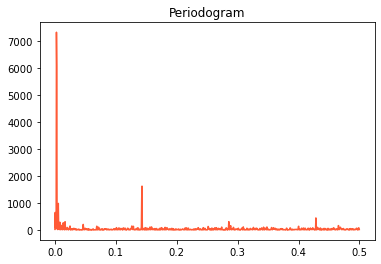

In [355]:
# We use for the sampling frequency 1 as we want to
# discover cycles over the original time steps.
f, Pxx = signal.periodogram(df_newmodel_2.Gesamt, fs = 1, window='hanning', scaling='spectrum')
plt.plot(f, Pxx, color = NF_ORANGE)
plt.title('Periodogram')
plt.show()

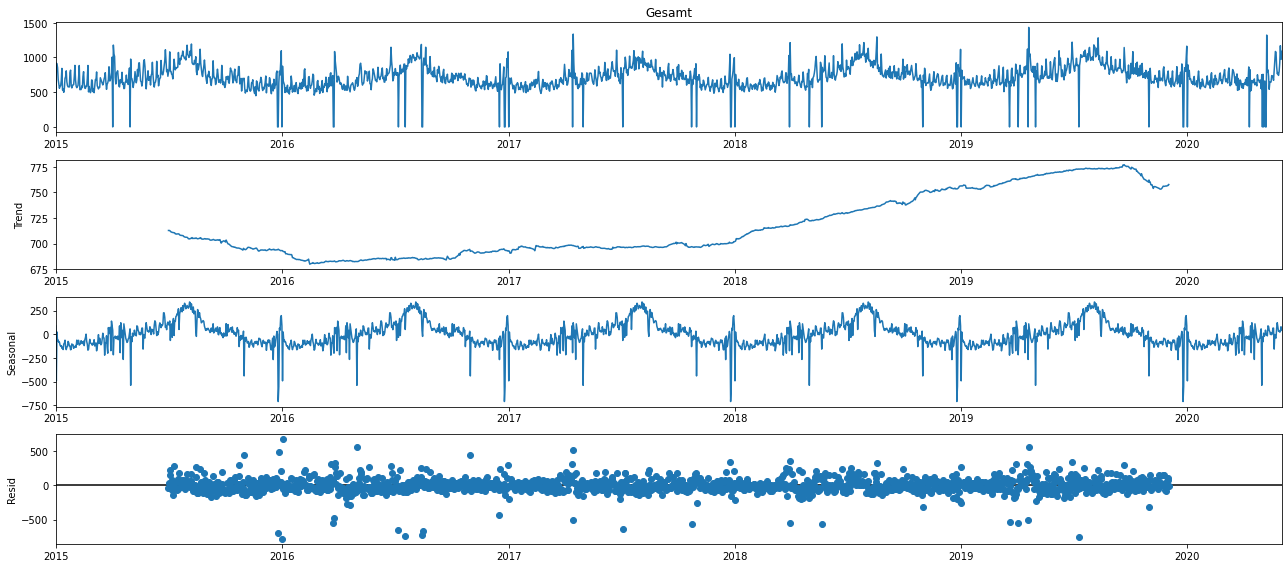

In [356]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Gesamt

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

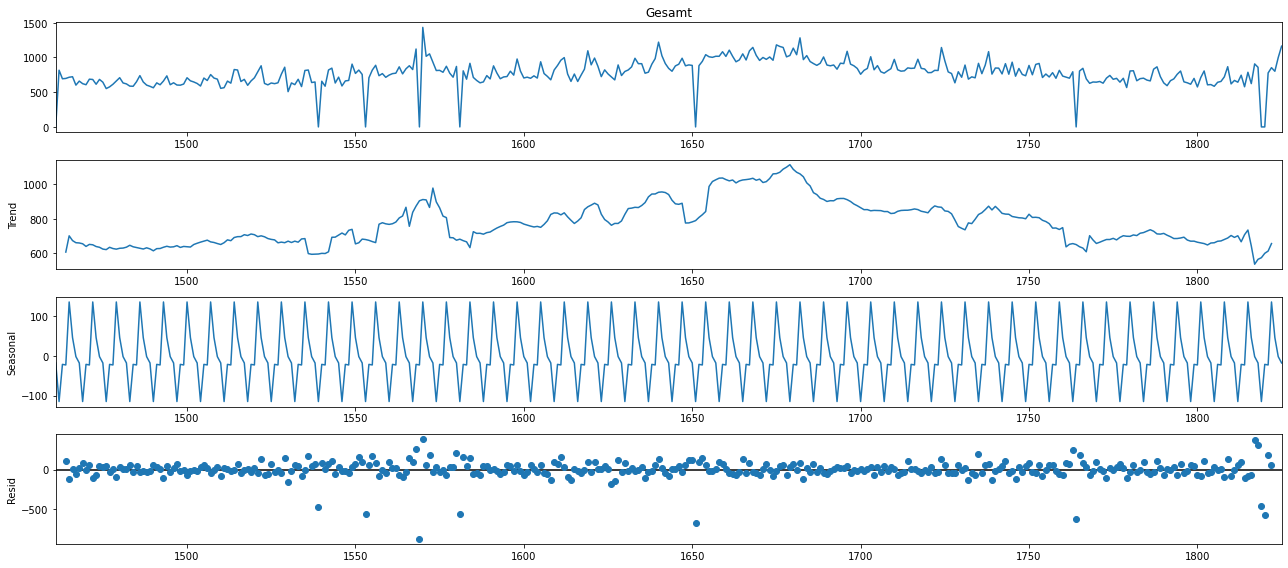

In [357]:
Jahr = 2019
#for idx,fil in enumerate([df_new_1,df_new_2,df_new_3],1):
y = df_new_2[df_newmodel_2.index.year == Jahr].Gesamt
#sum(axis=1)
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=7)
fig = decomposition.plot()
       
plt.show()

### Analysis on Articlegroups

#### Weizenbrot

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne decreases over the years.`
-  `There is a weekly and yearly saisonality.`

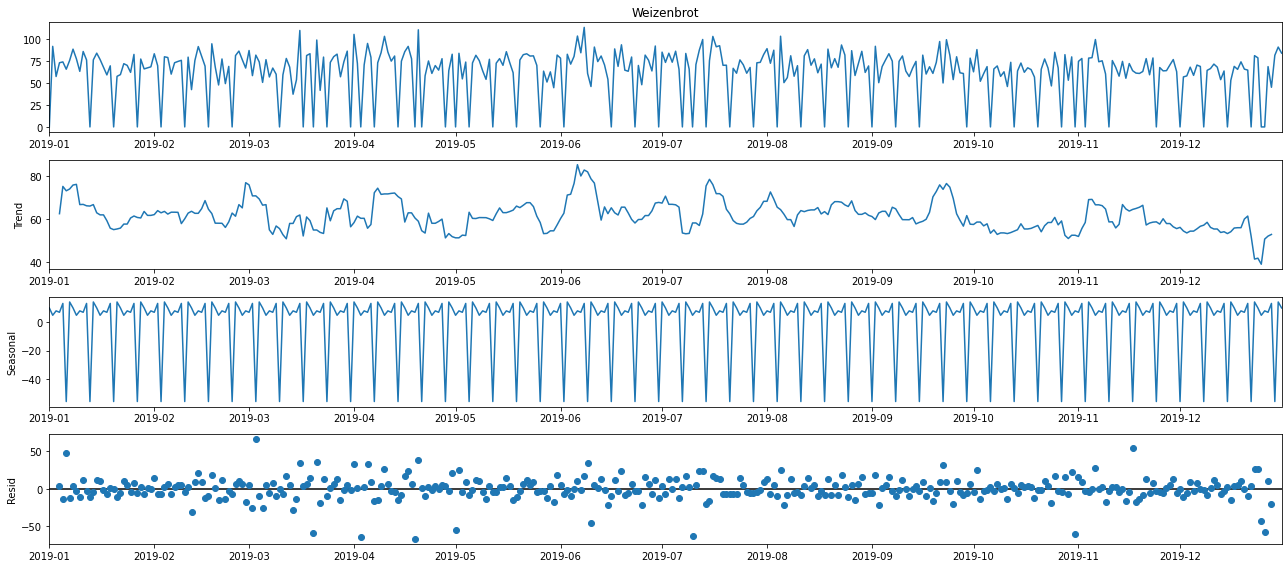

In [358]:
Jahr = 2019
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year == Jahr].Weizenbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=7)
fig = decomposition.plot()
       
plt.show()

#### Mischbrot

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the years.`
- `There is a weekly and yearly saisonality.`

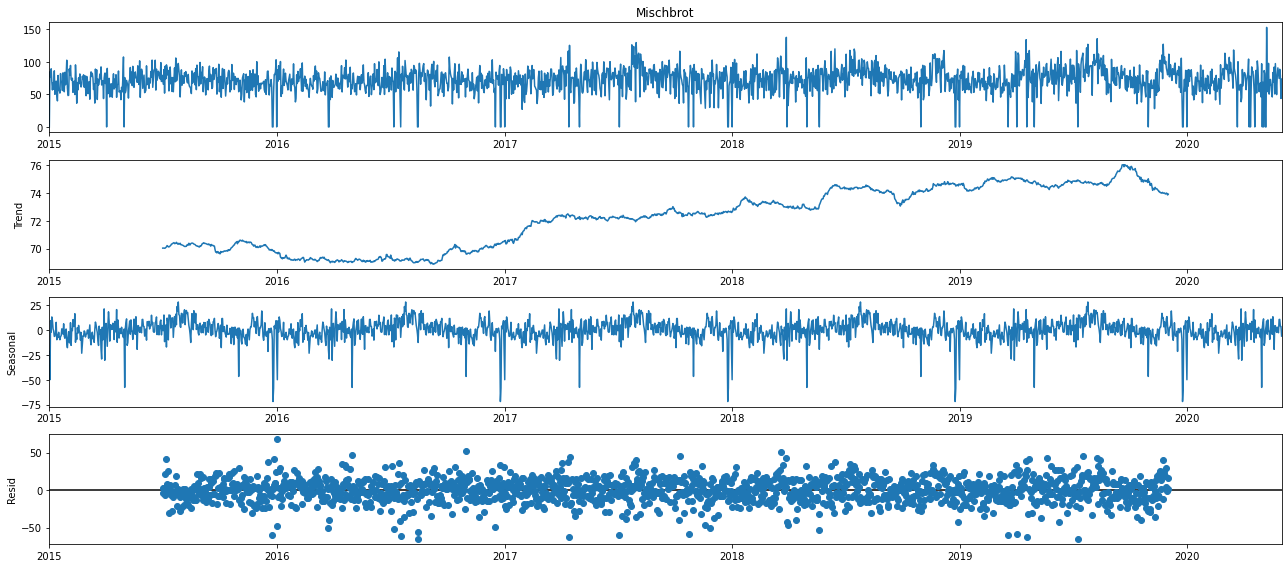

In [359]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Mischbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Vollkornbrot

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the years.`
- `There is a weekly saisonality which means period=7.`

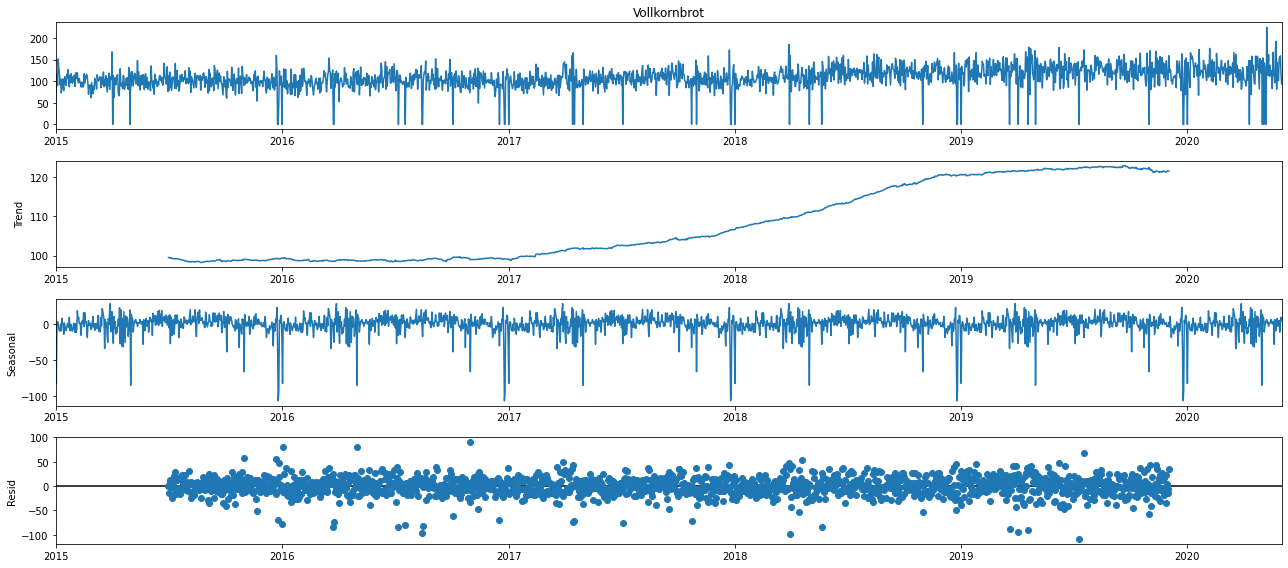

In [360]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Vollkornbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Spezialbrot

**Conclusions**
- `After the launch of the product in 2016 the sales volumne is relativly contant over the years.`
- `There is a weekly and yearly saisonality.`

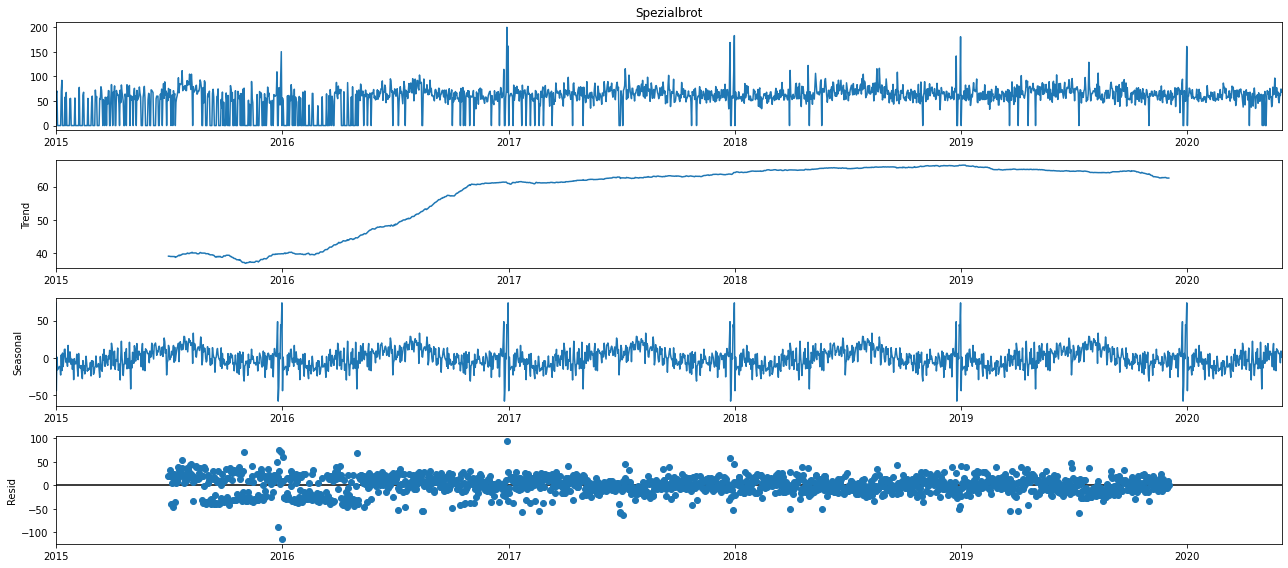

In [361]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Spezialbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Stangenbrot

**Conclusions**
- `The is a trend which can be seen for period=365. The sales volumne first increases until 2018 and than increase.`
- `There is a weekly and yearly saisonality.`

In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Stangenbrote

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Brötchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the last 3 years.`
- `There is a weekly saisonality which means period=7.`

In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Brötchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Süsse Brötchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the last 3 years. The plots look very similar to those of previous articlegroup Brötchen.`
- `There are weekly and yearly patterns.`

In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Süsse_Brötchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=7)
fig = decomposition.plot()
       
plt.show()

#### Herzhafte Brötchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the last 3 years. The plots look very similar to those of previous articlegroups Brötchen an Süsse_Brötchen.

In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Herzhafte_Brötchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### KonditoreiBlech

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne decreases since 2017. The plots look very similar to those of previous articlegroups Brötchen an Süsse_Brötchen.`
-`There are weekly and yearly patterns within the data.`


In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].KonditoreiBlech

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Stückgebäck

**Conclusions**

- `You can see peaks for every New Year's Eve. Inspite of this peaks, the values are rel. constant over the years.`
- `There are weak weekly and yearly patterns within the data.`


In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Stückgebäck

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Blechkuchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases since 2018.`
- `There are weekly and yearly patterns within the data.`


In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Blechkuchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Weihnachtsartikel

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases since 2017.`
- `There are hugh yearly patterns within the data, which does not surprise.`


In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Weihnachtsartikel

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

## Lag Plots

### Filiale 2

In [ ]:
# Make the graph 20 inches by 10 inches
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    lag_plot(df_basis_2['%s' % (name)],ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

## Autocorrelation Plots

### Before Corona

In [ ]:

y_2_gesamt=df_newmodel_2.Gesamt[:'15.03.2020']


#### Filiale 2

**Conclusions**
- `From the plot you can see there is a high peak in correlation at the lag of 7th day, then again on the 14th day
and so on. The series is perfectly autocorrelated with a lag of 1 week.`
- `This is valid for all single articlegroups with the exception Weihnachtsartikel. See single plots.`
- `For all articlegroups except Brot(Vollkornbrot, Weizenbrot,..) you see a  peak in correlation at the lag of 365th day.`


In [ ]:
# Autocorrelation totalsales  - Filiale 2
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15,5))
autocorrelation_plot(df_new_2.Gesamt).set_title(" Autocorrelation totalsales 2019 - Filiale 2")
plt.show()

In [ ]:
#fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
#fig.suptitle('AC and PAC for Filiale 2')
#sm.graphics.tsa.plot_acf(df_new_2.Gesamt.squeeze(), lags=20, ax=ax1)
#sm.graphics.tsa.plot_pacf(df_new_2.Gesamt.squeeze(), lags=20, ax=ax2)
#plt.show()


In [ ]:
# Analyse weekly dependencies
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    autocorrelation_plot(df_basis_2['%s' % (name)],ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

In [ ]:
# Analyse weekly dependencies - ACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_acf(df_basis_2['%s' % (name)],lags=20,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

In [ ]:
# Analyse weekly dependencies - PACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_pacf(df_basis_2['%s' % (name)],lags=20,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

In [ ]:
# Analyse yearly dependencies - ACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_acf(df_basis_2['%s' % (name)],lags=365,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

In [ ]:
# Analyse yearly dependencies - PACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_pacf(df_basis_2['%s' % (name)],lags=365,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

### Corona

**Conclusions**
- `The Sales cannot be predicted under the changing corona circumstances.So I decided to not predict sales with date after 15.03.2020.`

In [ ]:
y_corona=df_newmodel.Gesamt['01.03.2020':]


In [ ]:
# Autocorrelation totalsales 2020
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15,5))
autocorrelation_plot(df_newmodel_2.Gesamt['15.03.2020':]).set_title(" Autocorrelation totalsales until 2020 - Total")

plt.show()

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('AC and PAC during corona')
sm.graphics.tsa.plot_acf(df_newmodel_2.Gesamt['15.03.2020':].squeeze(), lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(df_newmodel_2.Gesamt['15.03.2020':].squeeze(), lags=40, ax=ax2)
plt.show()

## Check Stationarity

**Conclusions**
- `None of the series is stationary. To use ARIMA or VARIMA/VARIMAX I need to use differencing the Series.`
- `This need to be done one or more times per series with the result that the series is  difference-stationary.`
- `The number of transformations which have to be done can be estimated via auto arima. See next section.`


In [ ]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test short
from statsmodels.tsa.stattools import adfuller
def adf_test_long(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC',maxlag=365)
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
     
    p = adf['p-value']
    if p <= signif:
        pass
        #print(f" Series is Stationary")
        
    else:
        print(f"Ergebnis für Timeseries {name}:")
        print (adf)
        print(f" Series is Non-Stationary")


In [ ]:
def adf_test_long_einzel(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC',maxlag=365)
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
     
    p = adf['p-value']
    if p <= signif:
        pass
        print(f" Series is Stationary")
        print (adf)
    else:
        print(f"Ergebnis für Timeseries:")
        print (adf)
        print(f" Series is Non-Stationary")


In [ ]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC',maxlag=365)
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    
    p = adf['p-value']
    if p <= signif:
        pass
        #print(f" Series is Stationary")
    else: 
        print(f"Ergebnis für Timeseries {name}: Series is Non-Stationary")
        #print (adf)
        
#apply adf test on the series

### Filiale 2

In [ ]:
#Apply Check to timeseries of Filiale 1
for name in df_basis_2.columns:
    adf_test_long(df_basis_2[name])
    

In [ ]:
#Apply Check to timeseries of Filiale 2
for name in df_basis_2.columns:
    adf_test(df_basis_2[name])
    

## Check Causality

**Conclusions**
- `Looking at the p-Values we can assume that almost all variables are interchangeably each user.`
- `A exception is the articlegroup Blechkuchen.`
- `Overall this justifies an multivariate approach for prediction.`

In [ ]:
maxlag=12
test = 'ssr-chi2test'

def grangers_causality_matrix(X_train, variables,Filiale, test = 'ssr_chi2test', verbose=False):
   dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
   for c in dataset.columns:
    for r in dataset.index:
        test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
        min_p_value = np.min(p_values)
        dataset.loc[r,c] = min_p_value
        
    dataset.columns = [var + '_x_'+ Filiale for var in variables]
    dataset.index = [var + '_y' for var in variables]

    return dataset


In [ ]:
df_basisnew_2=df_newmodel_2.iloc[:,0:12]

In [ ]:
result_2=grangers_causality_matrix(df_basisnew_2, df_basisnew_2.columns,Filiale='Filiale_2')


## Cointegrationtest

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

### Filiale 2

In [ ]:
cointegration_test(df_basisnew_2)

# Modelling

## Metrics

**Conclusions**
- `I choose MAE and MAPE as Performance Measures for my project.`

I would analyse the results from the different models via the two different metrics mean absolute error **MAE** which is available via Sklearn.metrics and via the metrics mean absolute percentage error called **MAPE**.

There is no inbuilt function in sci-kit learn, so i define a custom function to calculate this measure. I adjusted the commom measure in the way that i do not consider all closed days of a Filiale.


In [304]:
#calculate mean absolute forecast error which only take actual values unequal to zero in consideration
def mean_absolute_error_nz(actual, predicted): 
    
    nz_1=(actual==0)
    actual_nz=actual[nz_1==0]
    
    difference_nz=actual-predicted
    difference_nz.dropna()
    return np.mean(np.abs((difference_nz)) )

In [305]:
#calculate mean absolute percentage forecast error
def mean_absolute_percentage_error(actual, predicted): 
    
    nz_1=(actual==0)
    actual_nz=actual[nz_1==0]
    
    difference_nz=actual-predicted
    difference_nz.dropna()
    return np.mean(np.abs((difference_nz) / actual_nz)) * 100

## Test-/Train-Split

Split into train and test datasets to build the model on the training dataset and forecast using the test dataset. I decide to use the first 4 years for training and the period since 01.01.2019 for testing. 

In [ ]:
# use past 4 years data to forecast the next 15 months until corona

start_train='01.01.2016'
end_train = '31.12.2018'
start_test='01.01.2019'
corona='15.03.2020'

In [ ]:
# Basismodel
train_basis_2 = df_newmodel_2[:end_train].copy()
test_basis_2 = df_newmodel_2[end_train:corona].copy()

In [371]:
train_new_2 = df_newmodel_2[start_train:end_train].copy()
test_new_2 = df_newmodel_2[start_test:corona].copy()

## Baseline Model

The moving average value can also be used directly to make predictions as a naive model and baseline for further 
on analysis. The fit would has been better if trend and seasonality components of the time series have already been removed or adjusted for.

In [306]:
# moving average smoothing as a forecast model
from math import sqrt
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [307]:
df_results_Baseline = pd.DataFrame( 
                  columns=['Model', 'Label','MAE_BASELINE'])

In [ ]:
df_results_Baseline= pd.read_csv("df_results_Baseline")
df_results_Baseline

In [369]:
# Build Moving Average with window=7 as Baseline 
var=df_newmodel_2.iloc[:,0:12].columns.tolist() 
test=["test_"+ str(i) for i in range(1,13)]
history=["history_"+ str(i) for i in range(1,13)]
predictions=["predictions_"+ str(i) for i in range(1,13)]

for j in range(0,12):

   window = 7
   history[j] =[df_newmodel_2["%s" % (var[j])][i] for i in range(window)]   
   test[j] = [df_newmodel_2["%s" % (var[j])] for i in range(window, len(df_newmodel_2["%s" % (var[j])]))]
   print
   predictions[j] = []
   #walk forward over time steps in test
   for t in range(len(test[j])):
        length = len(history[j])
        yhat = mean([history[j][i] for i in range(length-window,length)]) 
        obs = test[j][t]
        predictions[j].append(yhat)
        history[j].append(obs)


In [308]:
X_1=df_new_2.Weizenbrot  
window = 7
history_1 = [X_1[i] for i in range(window)]  
test_1 = [X_1[i] for i in range(window, len(X_1))] 
predictions_1 = []
#walk forward over time steps in test
for t in range(len(test_1)):
      length = len(history_1)
      yhat = mean([history_1[i] for i in range(length-window,length)]) 
      obs = test_1[t]
      predictions_1.append(yhat)
      history_1.append(obs)

In [309]:
X_2=df_new_2.Mischbrot  
window = 7
history_2 = [X_2[i] for i in range(window)]  
test_2 = [X_2[i] for i in range(window, len(X_2))] 
predictions_2 = []
#walk forward over time steps in test
for t in range(len(test_2)):
      length = len(history_2)
      yhat = mean([history_2[i] for i in range(length-window,length)]) 
      obs = test_2[t]
      predictions_2.append(yhat)
      history_2.append(obs)

In [310]:
X_3=df_new_2.Vollkornbrot 
window = 7
history_3 = [X_3[i] for i in range(window)]  
test_3 = [X_3[i] for i in range(window, len(X_3))] 
predictions_3 = []
#walk forward over time steps in test
for t in range(len(test_3)):
      length = len(history_3)
      yhat = mean([history_3[i] for i in range(length-window,length)]) 
      obs = test_3[t]
      predictions_3.append(yhat)
      history_3.append(obs)    

In [311]:
X_4=df_new_2.Spezialbrot 
window = 7
history_4 = [X_4[i] for i in range(window)]  
test_4 = [X_4[i] for i in range(window, len(X_4))] 
predictions_4 = []
#walk forward over time steps in test
for t in range(len(test_4)):
      length = len(history_4)
      yhat = mean([history_4[i] for i in range(length-window,length)]) 
      obs = test_4[t]
      predictions_4.append(yhat)
      history_4.append(obs)   

In [312]:
X_5=df_new_2.Stangenbrote
window = 7
history_5 = [X_5[i] for i in range(window)]  
test_5 = [X_5[i] for i in range(window, len(X_5))] 
predictions_5 = []
#walk forward over time steps in test
for t in range(len(test_5)):
      length = len(history_5)
      yhat = mean([history_5[i] for i in range(length-window,length)]) 
      obs = test_5[t]
      predictions_5.append(yhat)
      history_5.append(obs)   

In [313]:
X_6=df_new_2.Brötchen   
window = 7
history_6 = [X_6[i] for i in range(window)]  
test_6 = [X_6[i] for i in range(window, len(X_6))] 
predictions_6 = []
#walk forward over time steps in test
for t in range(len(test_6)):
      length = len(history_6)
      yhat = mean([history_6[i] for i in range(length-window,length)]) 
      obs = test_6[t]
      predictions_6.append(yhat)
      history_6.append(obs)
        

In [314]:
X_7=df_new_2.Süsse_Brötchen   
window = 7
history_7 = [X_7[i] for i in range(window)]  
test_7 = [X_7[i] for i in range(window, len(X_7))] 
predictions_7 = []
#walk forward over time steps in test
for t in range(len(test_7)):
      length = len(history_7)
      yhat = mean([history_7[i] for i in range(length-window,length)]) 
      obs = test_7[t]
      predictions_7.append(yhat)
      history_7.append(obs)

In [315]:
X_8=df_new_2.Herzhafte_Brötchen   
window = 7
history_8 = [X_8[i] for i in range(window)]  
test_8 = [X_8[i] for i in range(window, len(X_8))] 
predictions_8 = []
#walk forward over time steps in test
for t in range(len(test_8)):
      length = len(history_8)
      yhat = mean([history_8[i] for i in range(length-window,length)]) 
      obs = test_8[t]
      predictions_8.append(yhat)
      history_8.append(obs)

In [316]:
X_9=df_new_2.KonditoreiBlech   
window = 7
history_9 = [X_9[i] for i in range(window)]  
test_9 = [X_9[i] for i in range(window, len(X_9))] 
predictions_9 = []
#walk forward over time steps in test
for t in range(len(test_9)):
      length = len(history_9)
      yhat = mean([history_9[i] for i in range(length-window,length)]) 
      obs = test_9[t]
      predictions_9.append(yhat)
      history_9.append(obs)

In [317]:
X_10=df_new_2.Stückgebäck   
window = 7
history_10 = [X_10[i] for i in range(window)]  
test_10 = [X_10[i] for i in range(window, len(X_10))] 
predictions_10 = []
#walk forward over time steps in test
for t in range(len(test_10)):
      length = len(history_10)
      yhat = mean([history_10[i] for i in range(length-window,length)]) 
      obs = test_10[t]
      predictions_10.append(yhat)
      history_10.append(obs)

In [318]:
X_11=df_new_2.Blechkuchen  
window = 7
history_11 = [X_11[i] for i in range(window)]  
test_11 = [X_11[i] for i in range(window, len(X_11))] 
predictions_11 = []
#walk forward over time steps in test
for t in range(len(test_11)):
      length = len(history_11)
      yhat = mean([history_11[i] for i in range(length-window,length)]) 
      obs = test_11[t]
      predictions_11.append(yhat)
      history_11.append(obs)

In [319]:
X_12=df_new_2.Weihnachtsartikel  
window = 7
history_12 = [X_12[i] for i in range(window)]  
test_12 = [X_12[i] for i in range(window, len(X_12))] 
predictions_12 = []
#walk forward over time steps in test
for t in range(len(test_12)):
      length = len(history_12)
      yhat = mean([history_12[i] for i in range(length-window,length)]) 
      obs = test_12[t]
      predictions_12.append(yhat)
      history_12.append(obs)

In [320]:
mae_1=(mean_absolute_error(test_1, predictions_1))
mae_2=(mean_absolute_error(test_2, predictions_2))
mae_3=(mean_absolute_error(test_3, predictions_3))
mae_4=(mean_absolute_error(test_4, predictions_4))
mae_5=(mean_absolute_error(test_5, predictions_5))
mae_6=(mean_absolute_error(test_6, predictions_6))
mae_7=(mean_absolute_error(test_7, predictions_7))
mae_8=(mean_absolute_error(test_8, predictions_8))
mae_9=(mean_absolute_error(test_9, predictions_9))
mae_10=(mean_absolute_error(test_10, predictions_10))
mae_11=(mean_absolute_error(test_11, predictions_11))
mae_12=(mean_absolute_error(test_12, predictions_12))

In [370]:
# Write results to dateframe
mae=[mae_1,mae_2,mae_3,mae_4,mae_5,mae_6,mae_7,mae_8,mae_9,mae_10,mae_11,mae_12]

for j in range(0,12):
    
    df_results_Baseline.loc[str(j+1),:] = ['BASELINE',var[j],mae[j]]
 

In [ ]:
df_results_Baseline

In [ ]:
df_results_Baseline.to_csv("df_results_Baseline")

In [ ]:
mae_6=(mean_absolute_error(test_6, predictions_6))
#mpe_6=(mean_absolute_error_nz(test_6, predictions_6))
print('Ergebnis der Baseline for articlegroup Brötchen:')
print('Mean absolute Error MAE %.3f' % mae_6)
#print('Mean absolute percentage Error MAPE %.3f' % mpe_6)
# plot
plt.figure(figsize=(15,5))
pyplot.plot(test_6)
pyplot.plot(predictions_6, color='red') 
pyplot.show()
# zoom plot
plt.figure(figsize=(15,5))
pyplot.plot(test_6[:100]) 
pyplot.plot(predictions_6[:100], color='red') 
pyplot.show()

## Basismodell

### AUTOARIMA to find the best Parameterkombination

**Conclusions**
- `The best combination for articlegroup Brötchen is (1,0,3)x((1,0,1,7).`
- `The best combination für Süsse_Brötchen is .`

In [ ]:
train_basis_2.columns

### SARIMA Model

#### Summary of the results (MAE,MAPE)

In [ ]:
df_results_Sarima = pd.DataFrame( 
                  columns=['Model', 'Label','MAE','MAPE'])

In [367]:
df_results_Sarima

,Unnamed: 0,Model,Label,MAE,MAPE
0,1.0,SARIMA-BASIS,Weizenbrot,48.990918,76.329755
1,2.0,SARIMA-BASIS,Mischbrot,16.773704,20.651115
2,3.0,SARIMA-BASIS,Vollkornbrot,21.791997,15.315217
3,5.0,SARIMA-BASIS,Stangenbrote,11.860578,35.240243
4,6.0,SARIMA-BASIS,Brötchen,104.115612,26.984043
5,7.0,SARIMA-BASIS,Süsse_Brötchen,41.205578,17.162346
6,8.0,SARIMA-BASIS,Herzhafte_Brötchen,30.677182,24.751830
7,9.0,SARIMA-BASIS,KonditoreiBlech,99.847060,143.859152
8,10.0,SARIMA-BASIS,Stückgebäck,47.091111,31.914673
9,11.0,SARIMA-BASIS,Blechkuchen,35.407330,36.576361


In [ ]:
df_results_Sarima.to_csv("df_results_Sarima")

#### Weizenbrot

In [ ]:
#m = 7 as data contains daily observations SARIMAX(2, 0, 2)x(2, 0, [], 7)
model_autoarima_1 = auto_arima(train_basis_2['Weizenbrot'], seasonal=True,m=7)


In [376]:
# Model fit
sarima_basis_2_1 = sm.tsa.statespace.SARIMAX(train_basis_2['Weizenbrot'],order=(2,0,2),seasonal_order=((2, 0, 0, 7)),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()

In [ ]:
from sklearn.metrics import mean_squared_error
pred_basis_2_1 = sarima_basis_2_1.predict('01.01.2019','15.03.2020')[:]
MAE_1=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Weizenbrot'],pred_basis_2_1))
MAPE_1=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Weizenbrot'],pred_basis_2_1))
print('Results for Basismodel-Articlegroup Weizenbrot:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_1))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_1))

In [ ]:
df_results_Sarima.loc['1',:] = ['SARIMA-BASIS','Weizenbrot',MAE_1,MAPE_1]

#### Mischbrot

In [ ]:
#m = 7 as data contains daily observations SARIMAX(2, 0, 2)x(2, 0, [], 7)
model_autoarima_2 = auto_arima(train_basis_2['Mischbrot'], seasonal=True,m=7)


In [365]:
# Model fit
sarima_basis_2_2 = sm.tsa.statespace.SARIMAX(train_basis_2['Mischbrot'],order=(2,0,2),seasonal_order=((2, 0, 0, 7)),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()

In [ ]:
pred_basis_2_2 = sarima_basis_2_2.predict('01.01.2019','15.03.2020')[:]

MAE_2=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Mischbrot'],pred_basis_2_2))
MAPE_2=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Mischbrot'],pred_basis_2_2))
print('Results for Basismodel-Articlegroup Mischbrot:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_2))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_2))

df_results_Sarima.loc['2',:] = ['SARIMA-BASIS','Mischbrot',MAE_2,MAPE_2]

#### Vollkornbrot

In [ ]:
#m = 7 as data contains daily observations SARIMAX(0, 1, 1)x(0, 0, [1, 2], 7)
model_autoarima_3 = auto_arima(train_basis_2['Vollkornbrot'], seasonal=True,m=7)


In [ ]:
# Model fit
sarima_basis_2_3 = sm.tsa.statespace.SARIMAX(train_basis_2['Vollkornbrot'],order=(0,1,1),seasonal_order=((0, 0, 1, 7)),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()

In [ ]:
pred_basis_2_3 = sarima_basis_2_3.predict('01.01.2019','15.03.2020')[:]

MAE_3=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Vollkornbrot'],pred_basis_2_3))
MAPE_3=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Vollkornbrot'],pred_basis_2_3))
print('Results for Basismodel-Articlegroup Vollkornbrot:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_3))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_3))

df_results_Sarima.loc['3',:] = ['SARIMA-BASIS','Vollkornbrot',MAE_3,MAPE_3]

#### Spezialbrot

In [ ]:
#m = 7 as data contains daily observations SARIMAX(1, 1, 1)x(2, 0, [1, 2], 7) / SARIMAX(5, 1, 5)
model_autoarima_4 = auto_arima(train_basis_2['Spezialbrot'], seasonal=True,m=1)
#model_autoarima_4.summary()

In [ ]:
# Model fit
sarima_basis_2_4 = sm.tsa.statespace.SARIMAX(train_basis_2['Spezialbrot'],order=(5,1,5),
                                             #seasonal_order=((2, 0, 1, 7)),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()

In [ ]:
pred_basis_2_4 = sarima_basis_2_4.predict('01.01.2019','15.03.2020')[:]

MAE_4=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Spezialbrot'],pred_basis_2_4))
MAPE_4=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Spezialbrot'],pred_basis_2_4))
print('Results for Basismodel-Articlegroup Spezialbrot:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_4))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_4))

df_results_Sarima.loc['4',:] = ['SARIMA-BASIS','Spezialbrot',MAE_4,MAPE_4]

#### Stangenbrote

In [ ]:
#m = 7 as data contains daily observations SARIMAX(1, 0, 0)x(1, 0, [1, 2], 7)
model_autoarima_5 = auto_arima(train_basis_2['Stangenbrote'], seasonal=True,m=1)
#model_autoarima_5.summary()

In [ ]:
# Model fit
sarima_basis_2_5 = sm.tsa.statespace.SARIMAX(train_basis_2['Stangenbrote'],order=(1,0,0),seasonal_order=((1, 0, 1, 7)),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()

In [ ]:
pred_basis_2_5= sarima_basis_2_5.predict('01.01.2019','15.03.2020')[:]

MAE_5=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Stangenbrote'],pred_basis_2_5))
MAPE_5=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Stangenbrote'],pred_basis_2_5))
print('Results for Basismodel-Articlegroup Stangenbrote:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_5))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_5))

df_results_Sarima.loc['5',:] = ['SARIMA-BASIS','Stangenbrote',MAE_5,MAPE_5]

#### Brötchen

In [ ]:
#m = 7 as data contains daily observations SARIMAX(1, 0, 3)x(2, 0, [1, 2], 7)
model_autoarima_6 = auto_arima(train_basis_2['Brötchen'], seasonal=True,m=7)


In [ ]:
# Model fit
sarima_basis_2_6 = sm.tsa.statespace.SARIMAX(train_basis_2['Brötchen'],order=(1,0,3),seasonal_order=(1,0,1,7),
                                enforce_stationarity=True, enforce_invertibility=False,freq='D').fit()
#sarima_basis_2_6.summary()

In [ ]:
pred_basis_2_6 = sarima_basis_2_6.predict('01.01.2019','15.03.2020')[:]

MAE_6=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Brötchen'],pred_basis_2_6))
MAPE_6=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Brötchen'],pred_basis_2_6))
print('Results for Basismodel-Articlegroup Brötchen:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_6))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_6))

df_results_Sarima.loc['6',:] = ['SARIMA-BASIS','Brötchen',MAE_6,MAPE_6]

#### Süsse_Brötchen

In [ ]:
#m = 7 as data contains daily observations SARIMAX(3, 0, 0)x(2, 0, [1], 7)
model_autoarima_7 = auto_arima(train_basis_2['Süsse_Brötchen'], seasonal=True,m=7)


In [ ]:
# Model fit
sarima_basis_2_7 = sm.tsa.statespace.SARIMAX(train_basis_2['Süsse_Brötchen'],order=(1,0,3),seasonal_order=(1,0,1,7),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarima_basis_2_7.summary()

In [ ]:
pred_basis_2_7 = sarima_basis_2_7.predict('01.01.2019','15.03.2020')[:]

MAE_7=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Süsse_Brötchen'],pred_basis_2_7))
MAPE_7=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Süsse_Brötchen'],pred_basis_2_7))
print('Results for Basismodel-Articlegroup Süsse_Brötchen:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_7))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_7))

df_results_Sarima.loc['7',:] = ['SARIMA-BASIS','Süsse_Brötchen',MAE_7,MAPE_7]

#### Herzhafte Brötchen

In [ ]:
#m = 7 as data contains daily observations SARIMAX(0, 1, 1)x(0, 0, [1, 2], 7)
model_autoarima_8 = auto_arima(train_basis_2['Herzhafte_Brötchen'], seasonal=True,m=7)


In [ ]:
# Model fit
sarima_basis_2_8 = sm.tsa.statespace.SARIMAX(train_basis_2['Herzhafte_Brötchen'],order=(0,1,1),seasonal_order=(0,0,1,7),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarima_basis_2_8.summary()

In [ ]:
pred_basis_2_8 = sarima_basis_2_8.predict('01.01.2019','15.03.2020')[:]

MAE_8=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Herzhafte_Brötchen'],pred_basis_2_8))
MAPE_8=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Herzhafte_Brötchen'],pred_basis_2_8))
print('Results for Basismodel-Articlegroup Herzhafte_Brötchen:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_8))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_8))

df_results_Sarima.loc['8',:] = ['SARIMA-BASIS','Herzhafte_Brötchen',MAE_8,MAPE_8]

#### KonditoreiBlech

In [ ]:
#m = 7 as data contains daily observations SARIMAX(2, 1, 2)x(2, 0, 2, 7)	
model_autoarima_9 = auto_arima(train_basis_2['KonditoreiBlech'], seasonal=True,m=7)

In [ ]:
# Model fit
sarima_basis_2_9 = sm.tsa.statespace.SARIMAX(train_basis_2['KonditoreiBlech'],order=(2,1,2),seasonal_order=(2,0,2,7),
                                enforce_stationarity=True, enforce_invertibility=False,freq='D').fit()
#sarima_basis_2_9.summary()

In [ ]:
pred_basis_2_9 = sarima_basis_2_9.predict('01.01.2019','15.03.2020')[:]

MAE_9=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['KonditoreiBlech'],pred_basis_2_9))
MAPE_9=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['KonditoreiBlech'],pred_basis_2_9))
print('Results for Basismodel-Articlegroup KonditoreiBlech:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_9))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_9))

df_results_Sarima.loc['9',:] = ['SARIMA-BASIS','KonditoreiBlech',MAE_9,MAPE_9]

#### Stückgebäck

In [ ]:
#m = 7 as data contains daily observations SARIMAX(1, 1, 1)
model_autoarima_10 = auto_arima(train_basis_2['Stückgebäck'], seasonal=True,m=1)


In [ ]:
# Model fit
sarima_basis_2_10 = sm.tsa.statespace.SARIMAX(train_basis_2['Stückgebäck'],order=(1,1,1),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarima_basis_2_10.summary()

In [ ]:
pred_basis_2_10 = sarima_basis_2_10.predict('01.01.2019','15.03.2020')[:]

MAE_10=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Stückgebäck'],pred_basis_2_10))
MAPE_10=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Stückgebäck'],pred_basis_2_10))
print('Results for Basismodel-Articlegroup Stückgebäck:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_10))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_10))

df_results_Sarima.loc['10',:] = ['SARIMA-BASIS','Stückgebäck',MAE_10,MAPE_10]

#### Blechkuchen

In [ ]:
#m = 7 as data contains daily observations SARIMAX(2, 0, 2)x(1, 0, [1], 7)
model_autoarima_11 = auto_arima(train_basis_2['Blechkuchen'], seasonal=True,m=7)

In [ ]:
#model_autoarima_11.summary()

In [ ]:
# Model fit
sarima_basis_2_11 = sm.tsa.statespace.SARIMAX(train_basis_2['Blechkuchen'],order=(2,0,2),seasonal_order=(1,0,1,7),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarima_basis_2_11.summary()
pred_basis_2_11 = sarima_basis_2_11.predict('01.01.2019','15.03.2020')[:]

MAE_11=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Blechkuchen'],pred_basis_2_11))
MAPE_11=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Blechkuchen'],pred_basis_2_11))
print('Results for Basismodel-Articlegroup Blechkuchen:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_11))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_11))

df_results_Sarima.loc['11',:] = ['SARIMA-BASIS','Blechkuchen',MAE_11,MAPE_11]

#### Weihnachtsartikel

In [ ]:
#m = 7 as data contains daily observations SARIMAX(2, 1, 1)x(2, 0, [1, 2], 7)
model_autoarima_12 = auto_arima(train_basis_2['Weihnachtsartikel'], seasonal=True,m=1)

In [ ]:
#model_autoarima_12.summary()

In [ ]:
# Model fit
sarima_basis_2_12 = sm.tsa.statespace.SARIMAX(train_basis_2['Weihnachtsartikel'],order=(2,1,1),
                                              #seasonal_order=(2,0,1,7),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarima_basis_2_13.summary()

In [ ]:
pred_basis_2_12 = sarima_basis_2_12.predict('01.01.2019','15.03.2020')[:]

MAE_12=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Weihnachtsartikel'],pred_basis_2_12))
MAPE_12=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Weihnachtsartikel'],pred_basis_2_12))
print('Results for Basismodel-Articlegroup Weihnachtsartikel:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_12))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_12))

df_results_Sarima.loc['12',:] = ['SARIMA-BASIS','Weihnachtsartikel',MAE_12,MAPE_12]

### Diagnostics for Brötchen

In [ ]:
sarima_basis_2_6.plot_diagnostics(figsize=(15, 12))

## New Model

### SARIMAX Model with exogenen Faktoren

In [ ]:
exog_train_new_2=train_new_2.iloc[:,13:25]
exog_test_new_2=test_new_2.iloc[:,13:25]
#exog_test_new_2

#### Summary of the results (MAE, MAPE)

In [ ]:
df_results_Sarimax = pd.DataFrame( 
                  columns=['Model', 'Label','MAE_NEW','MAPE_NEW'])

In [ ]:
df_results_Sarima= pd.read_csv("df_results_Sarima")

In [ ]:
df_vergleich=pd.merge(df_results_Sarimax,df_results_Sarima)
df_vergleich

In [ ]:
df_results_Sarimax.to_csv("df_results_Sarimax")

#### Weizenbrot

In [ ]:
# Model fit
sarimax_new_2_1 = sm.tsa.statespace.SARIMAX(train_new_2['Weizenbrot'],order=(2,0,3),seasonal_order=(2,0,0,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_1.summary()

In [ ]:
pred_new_2_1 = sarimax_new_2_1.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

In [337]:
MAE_1n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Weizenbrot'],pred_new_2_1.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_1n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Weizenbrot'],pred_new_2_1.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Weizenbrot:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_1n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_1n))

df_results_Sarimax.loc['1',:] = ['SARIMA-BASIS','Weizenbrot',MAE_1n,MAPE_1n]

Results for Basismodel-Articlegroup Weizenbrot:
SARIMAX model MAE: 16.94
SARIMAX model MAPE: 19.15%


#### Mischbrot

In [ ]:
# Model fit
sarimax_new_2_2 = sm.tsa.statespace.SARIMAX(train_new_2['Mischbrot'],order=(2,0,2),seasonal_order=(2,0,0,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_2.summary()

In [ ]:
pred_new_2_2 = sarimax_new_2_2.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

In [338]:
MAE_2n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Mischbrot'],pred_new_2_2.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_2n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Mischbrot'],pred_new_2_2.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Mischbrot:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_2n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_2n))

df_results_Sarimax.loc['2',:] = ['SARIMA-BASIS','Mischbrot',MAE_2n,MAPE_2n]

Results for Basismodel-Articlegroup Mischbrot:
SARIMAX model MAE: 13.14
SARIMAX model MAPE: 18.39%


#### Vollkornbrot

In [ ]:
# Model fit
sarimax_new_2_3 = sm.tsa.statespace.SARIMAX(train_new_2['Vollkornbrot'],order=(1,0,3),seasonal_order=(1,0,1,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_3.summary()

In [ ]:
pred_new_2_3 = sarimax_new_2_3.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

In [339]:
MAE_3n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Vollkornbrot'],pred_new_2_3.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_3n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Vollkornbrot'],pred_new_2_3.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Vollkornbrot:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_3n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_3n))

df_results_Sarimax.loc['3',:] = ['SARIMA-BASIS','Vollkornbrot',MAE_3n,MAPE_3n]

Results for Basismodel-Articlegroup Vollkornbrot:
SARIMAX model MAE: 17.10
SARIMAX model MAPE: 13.68%


#### Spezialbrot

In [340]:
# Model fit
sarimax_new_2_4 = sm.tsa.statespace.SARIMAX(train_new_2['Spezialbrot'],order=(1,1,0),seasonal_order=(2, 0, 1, 7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_4.summary()

pred_new_2_4 = sarimax_new_2_4.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

MAE_4n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Spezialbrot'],pred_new_2_4.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_4n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Spezialbrot'],pred_new_2_4.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Spezialbrot:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_4n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_4n))

df_results_Sarimax.loc['4',:] = ['SARIMA-BASIS','Spezialbrot',MAE_4n,MAPE_4n]

Results for Basismodel-Articlegroup Spezialbrot:
SARIMAX model MAE: 20.49
SARIMAX model MAPE: 34.45%


#### Stangenbrote

In [341]:
# Model fit
sarimax_new_2_5 = sm.tsa.statespace.SARIMAX(train_new_2['Stangenbrote'],order=(1,0,1),seasonal_order=((1, 1, 1, 7)),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_5.summary()

pred_new_2_5 = sarimax_new_2_5.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

MAE_5n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Stangenbrote'],pred_new_2_5.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_5n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Stangenbrote'],pred_new_2_5.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Stangenbrote:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_5n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_5n))

df_results_Sarimax.loc['5',:] = ['SARIMA-BASIS','Stangenbrote',MAE_5n,MAPE_5n]

Results for Basismodel-Articlegroup Stangenbrote:
SARIMAX model MAE: 11.95
SARIMAX model MAPE: 40.28%


#### Brötchen

In [ ]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(train_new_2['Brötchen'], exogenous=exog_train_new_2,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=7, max_q=7, m=7,
                           start_P=0, seasonal=True,
                            D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

#sxmodel.summary()

In [ ]:
# Model fit
sarimax_new_2_6 = sm.tsa.statespace.SARIMAX(train_new_2['Brötchen'],order=(2,0,3),seasonal_order=(2,0,1,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_6.summary()

In [342]:
pred_new_2_6 = sarimax_new_2_6.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

In [343]:
MAE_6n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Brötchen'],pred_new_2_6.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_6n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Brötchen'],pred_new_2_6.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Brötchen:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_6n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_6n))

df_results_Sarimax.loc['6',:] = ['SARIMA-BASIS','Brötchen',MAE_6n,MAPE_6n]

Results for Basismodel-Articlegroup Brötchen:
SARIMAX model MAE: 78.62
SARIMAX model MAPE: 18.87%


In [ ]:
#pred_new_2_6_dyn = sarimax_new_2_6.get_prediction(dynamic='2019-01-01')

#### Süsse Brötchen

In [344]:
# Model fit
sarimax_new_2_7 = sm.tsa.statespace.SARIMAX(train_new_2['Süsse_Brötchen'],order=(3,0,0),seasonal_order=(2,0,1,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_7.summary()

pred_new_2_7 = sarimax_new_2_7.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

MAE_7n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Süsse_Brötchen'],pred_new_2_7.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_7n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Süsse_Brötchen'],pred_new_2_7.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Süsse_Brötchen:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_7n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_7n))

df_results_Sarimax.loc['7',:] = ['SARIMA-BASIS','SüsseBrötchen',MAE_7n,MAPE_7n]

Results for Basismodel-Articlegroup Süsse_Brötchen:
SARIMAX model MAE: 28.23
SARIMAX model MAPE: 12.77%


#### Herzhafte Brötchen

In [ ]:
# Model fit
sarimax_new_2_8 = sm.tsa.statespace.SARIMAX(train_new_2['Herzhafte_Brötchen'],order=(3,0,0),seasonal_order=(2,0,1,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_8.summary()

In [345]:
pred_new_2_8 = sarimax_new_2_8.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

MAE_8n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Herzhafte_Brötchen'],pred_new_2_8.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_8n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Herzhafte_Brötchen'],pred_new_2_8.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Herzhafte_Brötchen:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_8n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_8n))

df_results_Sarimax.loc['8',:] = ['SARIMA-BASIS','Herzhafte_Brötchen',MAE_8n,MAPE_8n]

Results for Basismodel-Articlegroup Herzhafte_Brötchen:
SARIMAX model MAE: 28.90
SARIMAX model MAPE: 22.98%


#### KonditoreiBlech

In [346]:
# Model fit
sarimax_new_2_9 = sm.tsa.statespace.SARIMAX(train_new_2['KonditoreiBlech'],order=(2,1,2),seasonal_order=(2,0,2,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_9.summary()

pred_new_2_9 = sarimax_new_2_9.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

MAE_9n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['KonditoreiBlech'],pred_new_2_9.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_9n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['KonditoreiBlech'],pred_new_2_9.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup KonditoreiBlech:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_9n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_9n))

df_results_Sarimax.loc['9',:] = ['SARIMA-BASIS','KonditoreiBlech',MAE_9n,MAPE_9n]

Results for Basismodel-Articlegroup KonditoreiBlech:
SARIMAX model MAE: 36.09
SARIMAX model MAPE: 46.53%


#### Stückgebäck

In [347]:
# Model fit
sarimax_new_2_10 = sm.tsa.statespace.SARIMAX(train_new_2['Stückgebäck'],order=(1,0,0),
                                             #seasonal_order=(2,0,2,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_10.summary()

pred_new_2_10 = sarimax_new_2_10.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

MAE_10n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Stückgebäck'],pred_new_2_10.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_10n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Stückgebäck'],pred_new_2_10.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Stückgebäck:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_10n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_10n))

df_results_Sarimax.loc['10',:] = ['SARIMA-BASIS','Stückgebäck',MAE_10n,MAPE_10n]

Results for Basismodel-Articlegroup Stückgebäck:
SARIMAX model MAE: 41.71
SARIMAX model MAPE: 25.79%


#### Blechkuchen

In [ ]:
# Model fit
sarimax_new_2_11 = sm.tsa.statespace.SARIMAX(train_new_2['Blechkuchen'],order=(3,0,0),seasonal_order=(1,0,1,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_11.summary()

In [348]:
pred_new_2_11 = sarimax_new_2_11.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

In [349]:
MAE_11n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Blechkuchen'],pred_new_2_11.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_11n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Blechkuchen'],pred_new_2_11.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Blechkuchen:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_11n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_11n))

df_results_Sarimax.loc['11',:] = ['SARIMA-BASIS','Blechkuchen',MAE_11n,MAPE_11n]

Results for Basismodel-Articlegroup Blechkuchen:
SARIMAX model MAE: 33.93
SARIMAX model MAPE: 40.51%


#### Weihnachtsartikel

In [350]:
# Model fit
sarimax_new_2_12 = sm.tsa.statespace.SARIMAX(train_new_2['Weihnachtsartikel'],order=(1,1,1),
                                             #seasonal_order=(2,0,2,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_12.summary()

pred_new_2_12 = sarimax_new_2_12.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

MAE_12n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Weihnachtsartikel'],pred_new_2_10.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_12n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Weihnachtsartikel'],pred_new_2_10.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Weihnachtsartikel:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_12n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_12n))

df_results_Sarimax.loc['12',:] = ['SARIMA-BASIS','Weihnachtsartikel',MAE_12n,MAPE_12n]

Results for Basismodel-Articlegroup Weihnachtsartikel:
SARIMAX model MAE: 129.44
SARIMAX model MAPE: 19.87%


#### Adding shift(364) to cover yearly patterns

In [332]:
exog_train_adv_2=train_new_2.iloc[:,13:27]
exog_test_adv_2=test_new_2.iloc[:,13:27]

In [333]:
#exog_train_adv_2.info()

In [334]:
# Model fit
sarimax_adv_2_6 = sm.tsa.statespace.SARIMAX(train_new_2['Brötchen'],order=(1,0,3),seasonal_order=(1,0,1,7),
                                             exog = exog_train_adv_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_adv_2_6.summary()

In [335]:
pred_adv_2_6 = sarimax_adv_2_6.get_prediction(start=start_test,end=corona,exog = exog_test_adv_2)

In [336]:
print('Results for Basismodel-articlegroup Brötchen:')
print('SARIMA model MAE: {0:.2f}'.
      format(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Brötchen'],pred_adv_2_6.predicted_mean['01.01.2019':'15.03.2020'])))
print('SARIMA model MAPE: {0:.2f}%'.format(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Brötchen'],pred_adv_2_6.predicted_mean['01.01.2019':'15.03.2020'])))

Results for Basismodel-articlegroup Brötchen:
SARIMA model MAE: 75.54
SARIMA model MAPE: 18.57%


### Plotting

#### Vollkornbrot

In [ ]:
pd.DataFrame({'test':test_new_2['01.01.2019':'15.03.2020']['Vollkornbrot'],'pred':pred_new_2_2.predicted_mean['01.01.2019':'15.03.2020']}).plot();plt.show()

#### Brötchen

In [ ]:
pd.DataFrame({'test':test_new_2['01.01.2019':'15.03.2020']['Brötchen'],'pred':pred_new_2_6diff.predicted_mean['01.01.2019':'15.03.2020']}).plot();plt.show()

#### Stückgebäck

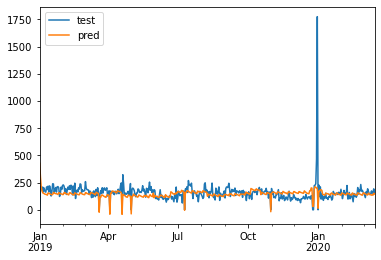

In [330]:
pd.DataFrame({'test':test_new_2['01.01.2019':'15.03.2020']['Stückgebäck'],'pred':pred_new_2_10.predicted_mean['01.01.2019':'15.03.2020']}).plot();plt.show()

#### Weihnachtsartikel

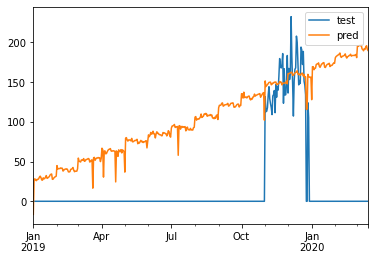

In [331]:
pd.DataFrame({'test':test_new_2['01.01.2019':'15.03.2020']['Weihnachtsartikel'],'pred':pred_new_2_12.predicted_mean['01.01.2019':'15.03.2020']}).plot();plt.show()

### Diagnostics

#### Diagnostics for Vollkornbrot

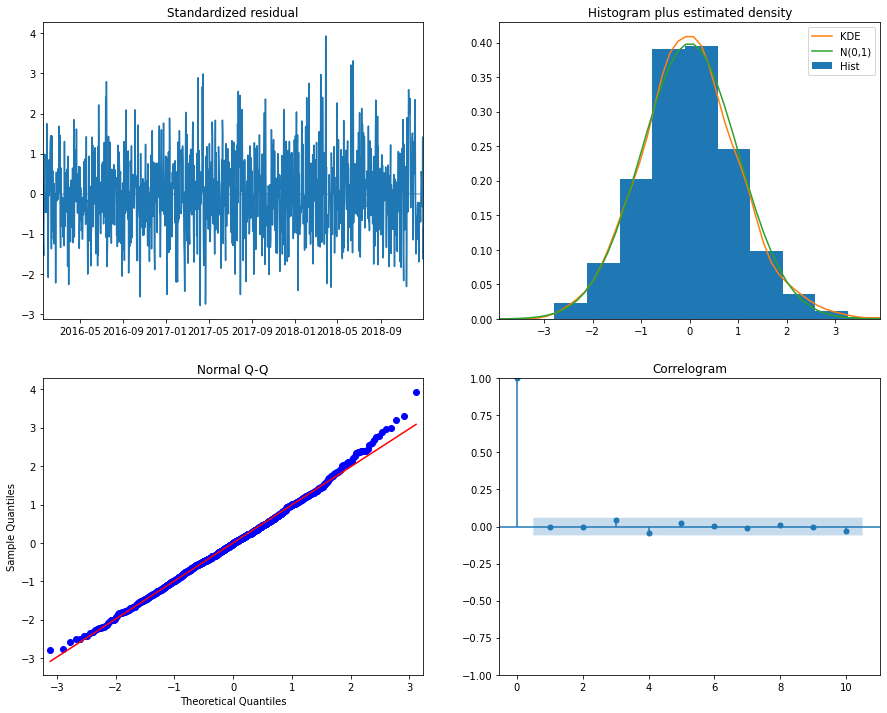

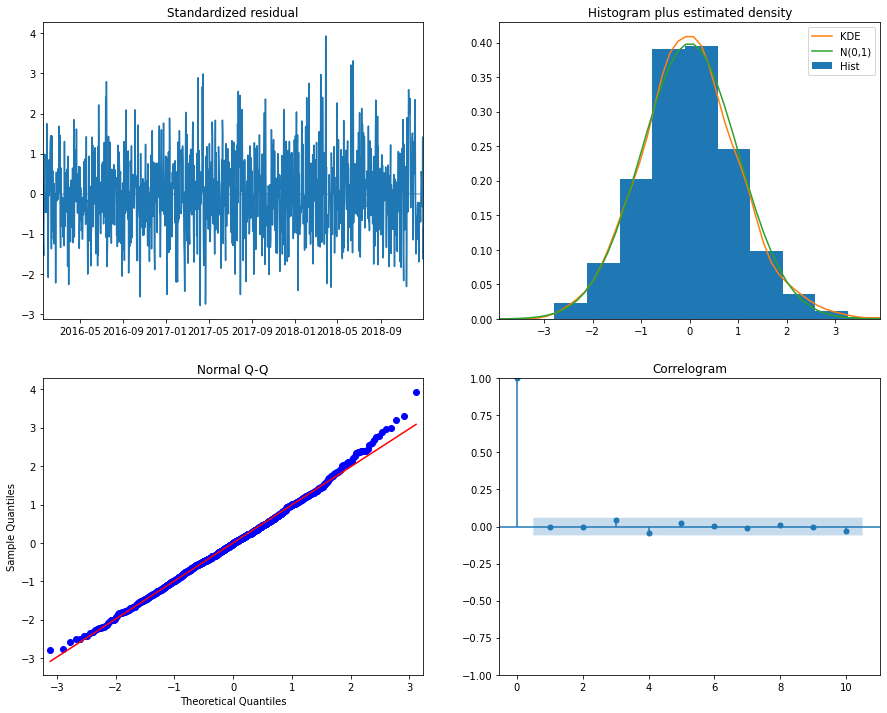

In [326]:
sarimax_new_2_2.plot_diagnostics(figsize=(15, 12))

#### Diagnostics for Brötchen

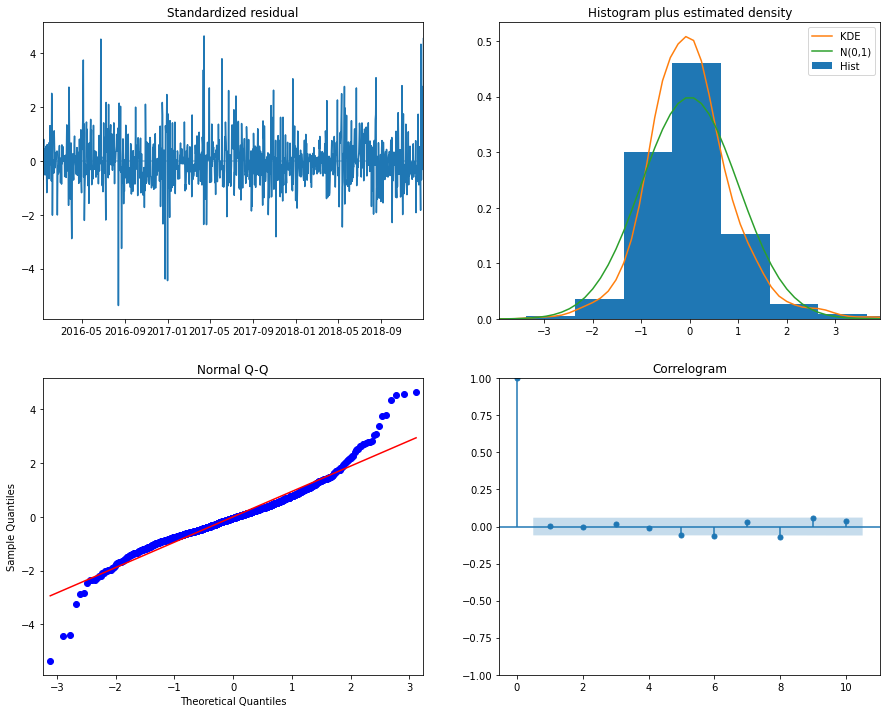

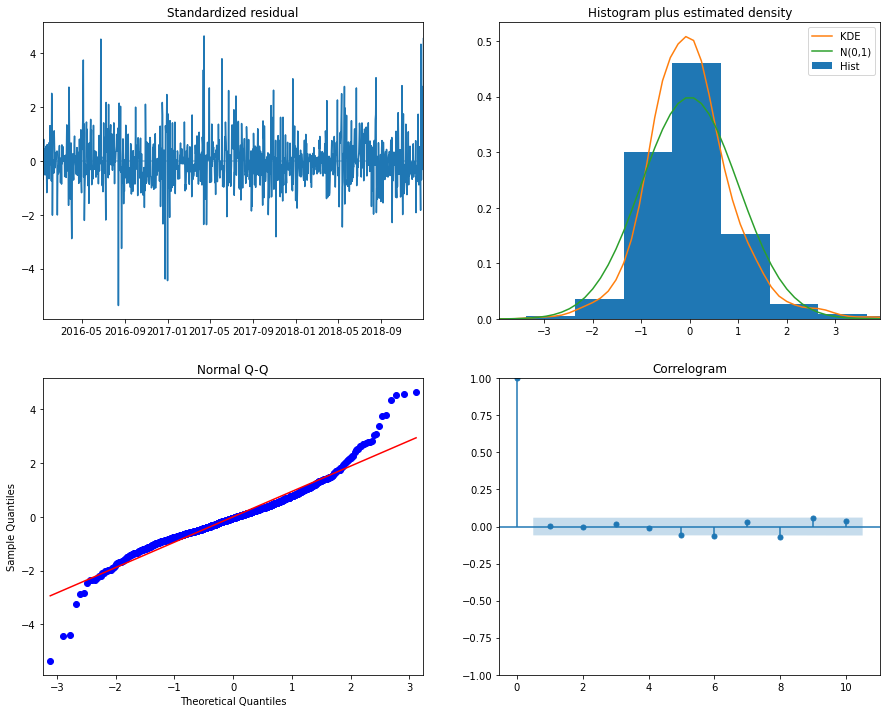

In [327]:
sarimax_adv_2_6.plot_diagnostics(figsize=(15, 12))

In [328]:
res_df_6_adv=pd.DataFrame(sarimax_adv_2_6.resid,columns=['resid'])

In [329]:
res_df_6.nlargest(5,'resid')

,resid
Datum,
2016-06-25,249.664380
2018-12-31,230.611400
2018-12-24,217.910092
2017-06-05,216.660797
2017-04-15,207.999549


#### Diagnostics for Süsse Brötchen

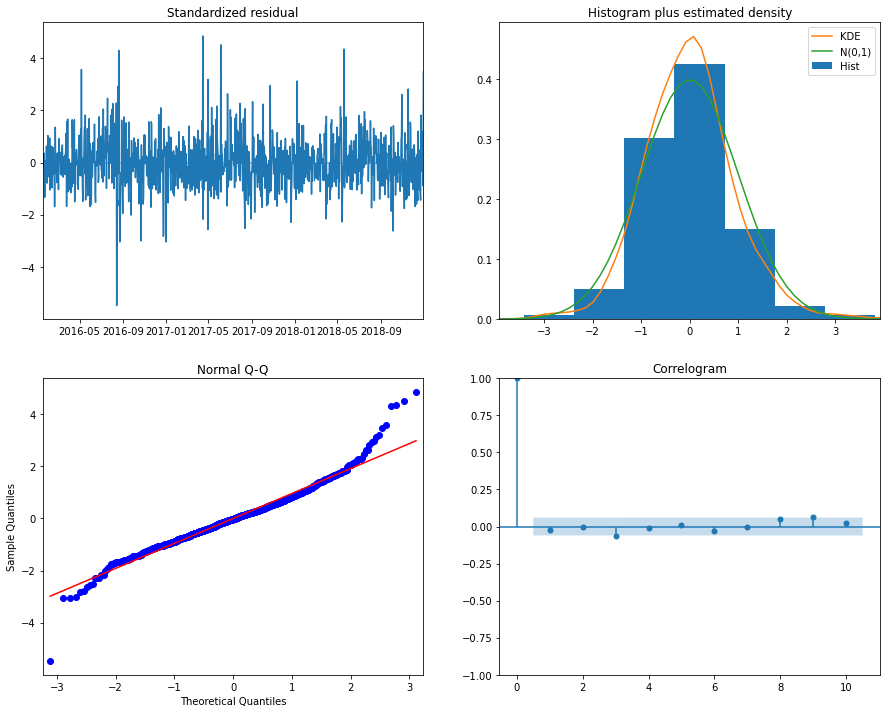

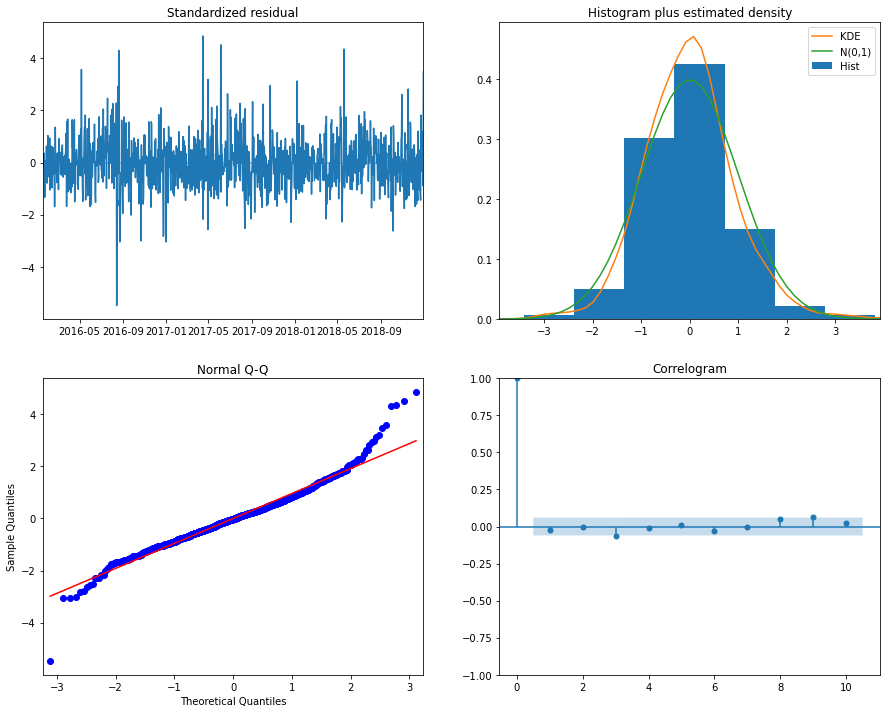

In [322]:
sarimax_new_2_7.plot_diagnostics(figsize=(15, 12))

#### Diagnostics for Stückgebäck

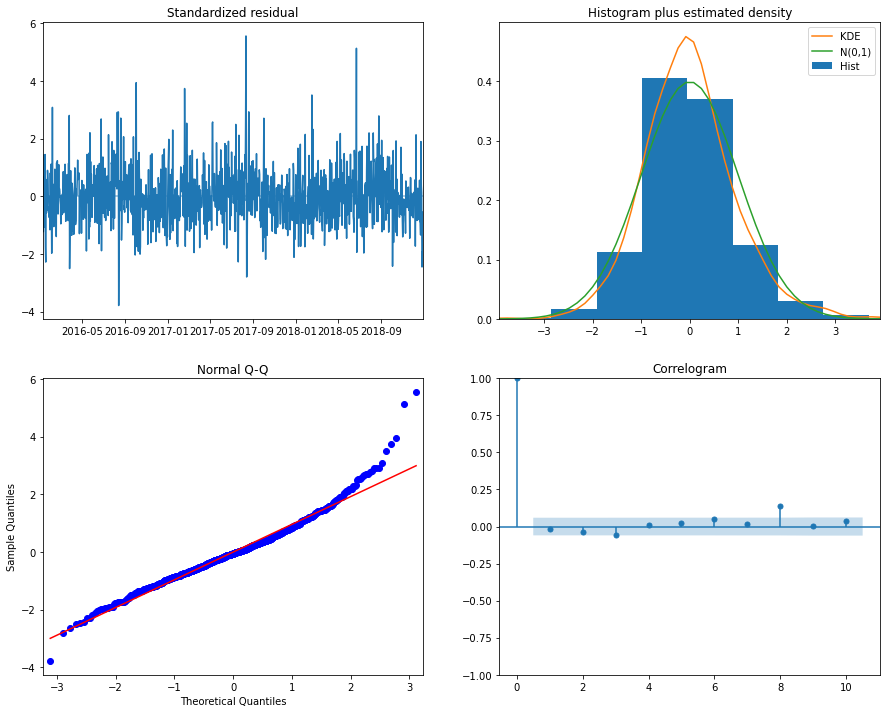

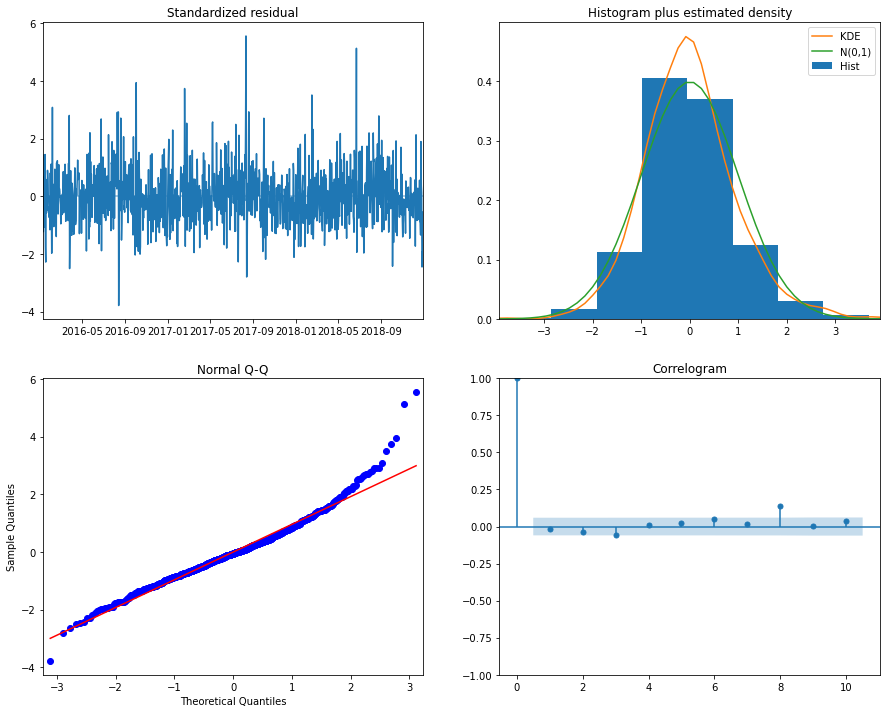

In [323]:
sarimax_new_2_11.plot_diagnostics(figsize=(15, 12))

In [324]:
res_df_11_new=pd.DataFrame(sarimax_new_2_11.resid,columns=['resid'])

In [325]:
res_df_11_new.nlargest(5,'resid')

,resid
Datum,
2017-08-12,165.396961
2018-06-23,152.681522
2016-10-03,117.236353
2017-02-18,111.162530
2018-02-16,104.479472


#### Diagnostics for Weihnachtsartikel

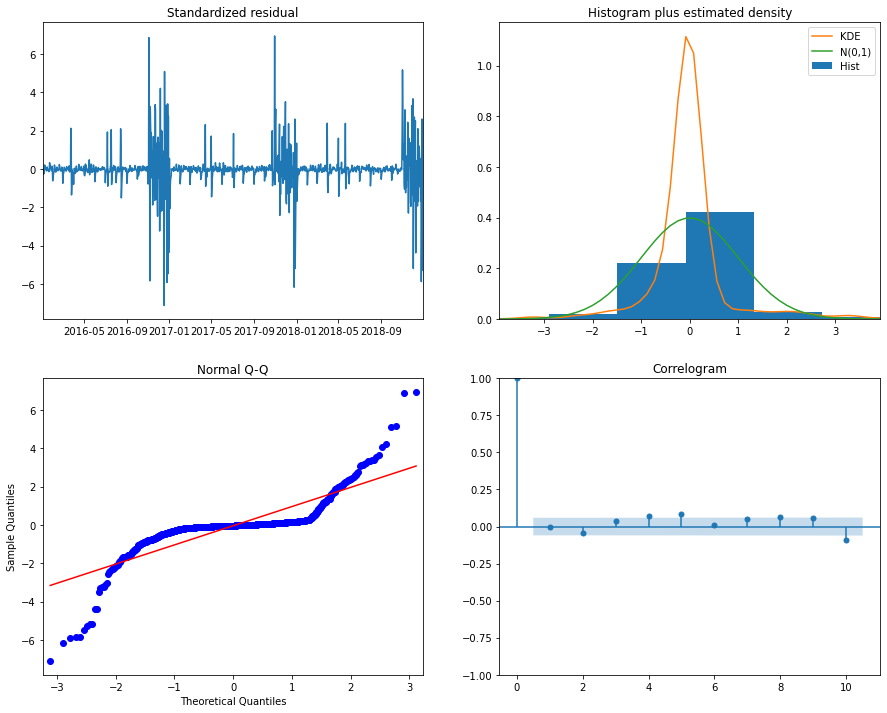

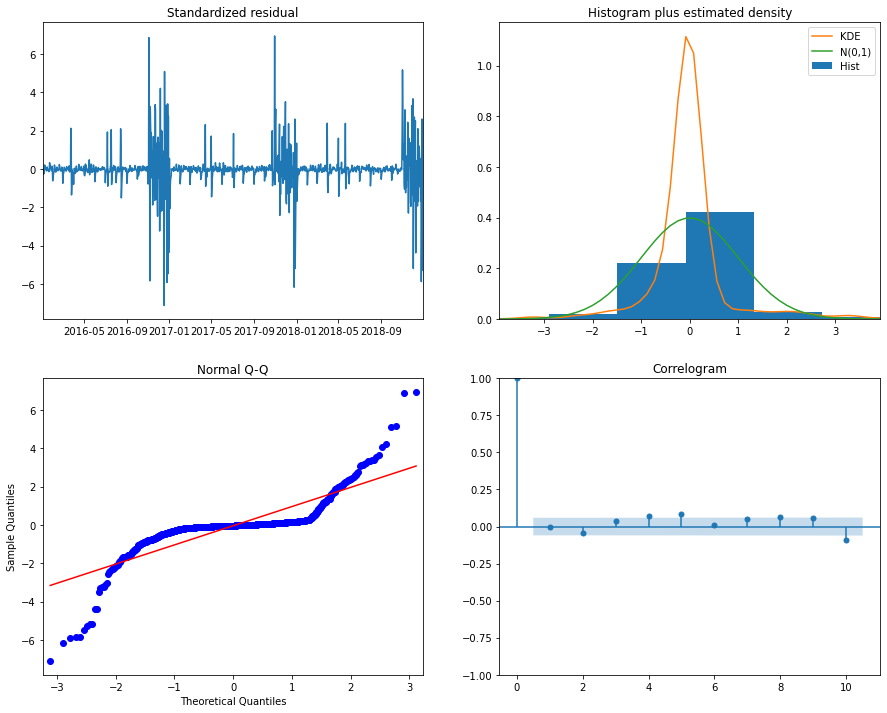

In [290]:
sarimax_new_2_12.plot_diagnostics(figsize=(15, 12))

### Optimazation 

#### Differencing

**Conclusions**
- `After the first differencation is the timesseries stationary.It is Integrated(1). `


In [291]:
adf_test_long_einzel(train_new_2['Brötchen'])

Ergebnis für Timeseries:
Test Statistic            -2.554666
p-value                    0.102733
# Lags                    55.000000
# Observations          1040.000000
Critical Value (1%)       -3.436653
Critical Value (5%)       -2.864323
Critical Value (10%)      -2.568252
dtype: float64
 Series is Non-Stationary


In [292]:
train_new_2['Brötchen'].diff().dropna()

Datum
2016-01-02    513.212373
2016-01-03    -55.017806
2016-01-04   -171.290047
2016-01-05     21.913730
2016-01-06    -55.473883
                 ...    
2018-12-27    488.618722
2018-12-28    -66.708315
2018-12-29     54.529782
2018-12-30     33.658732
2018-12-31    109.036188
Name: Brötchen, Length: 1095, dtype: float64

In [293]:
#ADF-test(differenced-time-series)
adf_test_long_einzel(train_new_2['Brötchen'].diff().dropna())


 Series is Stationary
Test Statistic            -5.236324
p-value                    0.000007
# Lags                    54.000000
# Observations          1040.000000
Critical Value (1%)       -3.436653
Critical Value (5%)       -2.864323
Critical Value (10%)      -2.568252
dtype: float64


In [294]:
test_new_2['Brötchen'].diff().dropna()

Datum
2019-01-02    418.883686
2019-01-03    -67.503505
2019-01-04    -30.111475
2019-01-05     37.316530
2019-01-06     43.642456
                 ...    
2020-03-11     53.771387
2020-03-12    -47.313414
2020-03-13     73.239408
2020-03-14    116.512224
2020-03-15    118.516984
Name: Brötchen, Length: 439, dtype: float64

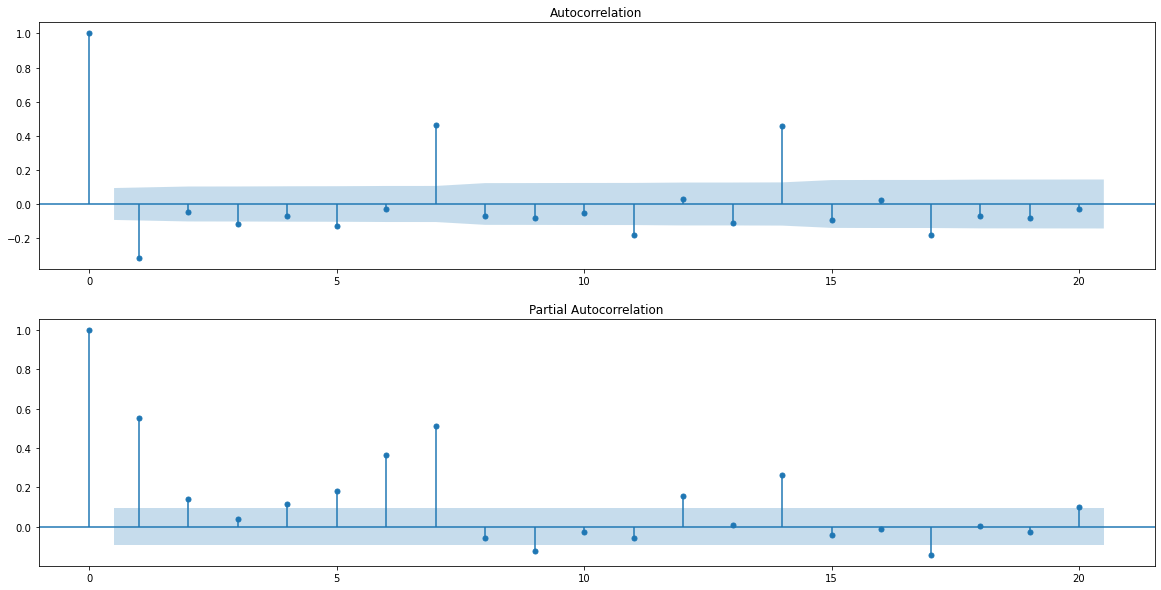

In [295]:
# use diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(test_new_2['Brötchen'].diff().dropna(), lags=20, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(test_new_2['Brötchen'].dropna(), lags=20, ax=ax[1])
plt.show()

In [296]:
model_autoarima_6 = auto_arima(train_basis_2['Brötchen'],d=1,p=7,Seasonal=True, m=7)
model_autoarima_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1461
Model:             SARIMAX(1, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -8673.538
Date:                                Wed, 11 Nov 2020   AIC                          17357.076
Time:                                        18:48:33   BIC                          17383.507
Sample:                                             0   HQIC                         17366.936
                                               - 1461                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2493      0.017     14.464      0.000       0.216       0.283
ma.L1         -0.9350      0.011    -83.064      0.000      -0.957      -0.913
ma.S.L7        0.3757      0.017     22.767      0.000       0.343       0.408
ma.S.L14       0.2023      0.025      8.146      0.000       0.154       0.251
sigma2      8450.8066    171.926     49.154      0.000    8113.838    8787.775
===================================================================================
Ljung-Box (Q):                      361.34   Jarque-Bera (JB):              2373.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.50
Prob(H) (two-sided):                  0.23   Kurtosis:                         9.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [297]:
# Model fit
sarimax_new_2_6diff = sm.tsa.statespace.SARIMAX(train_new_2['Brötchen'],order=(1, 1, 1), seasonal_order=(0, 0, [1, 2], 7)
                                             ,exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_6.summary()

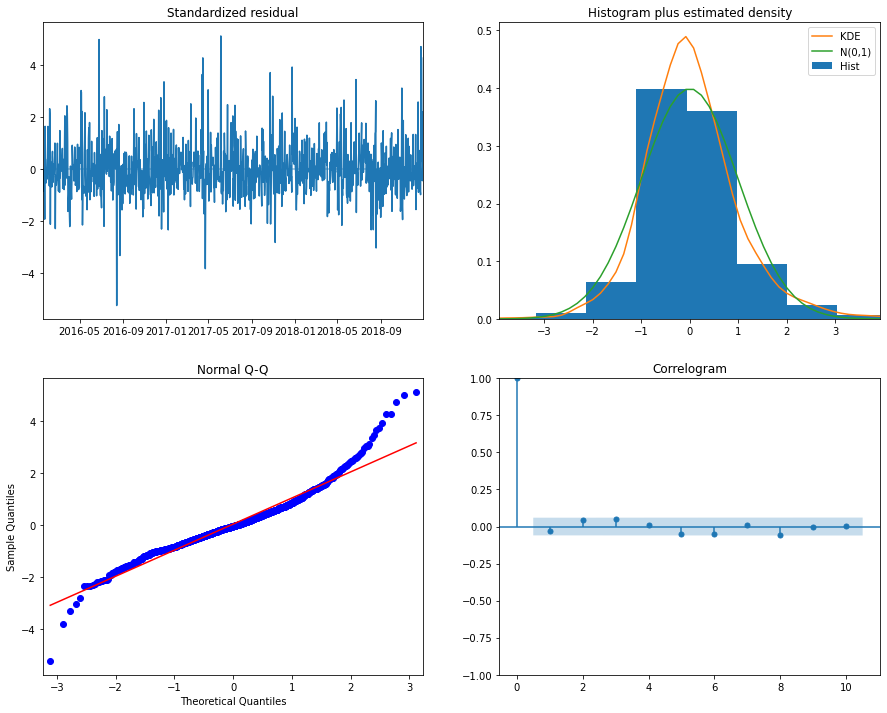

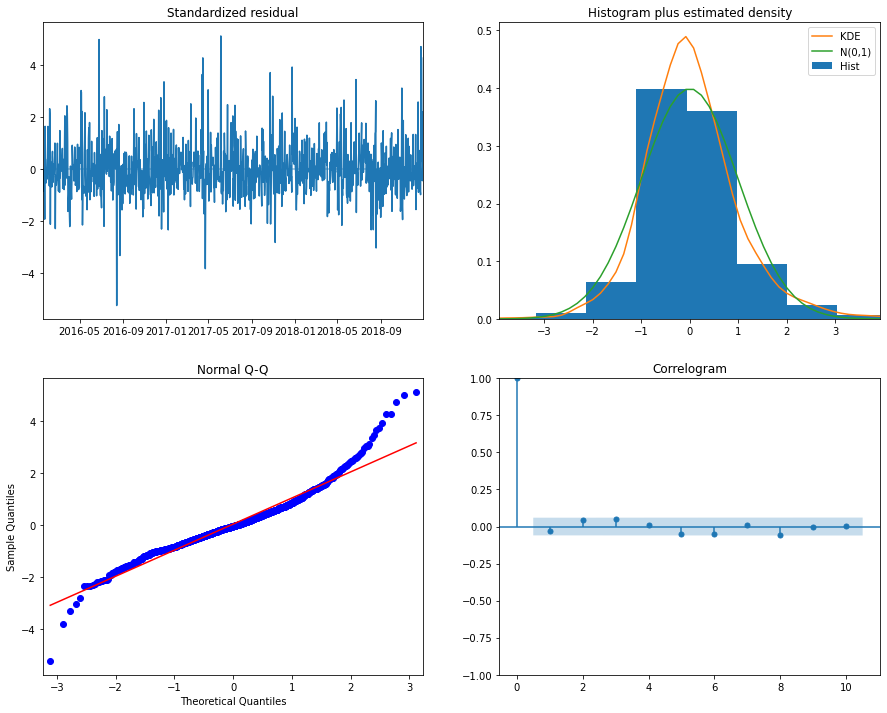

In [298]:
sarimax_new_2_6diff.plot_diagnostics(figsize=(15, 12))

In [299]:
pred_new_2_6diff = sarimax_new_2_6diff.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

In [300]:
MAE_6n2=(mean_absolute_error(test_new_2['Brötchen'],pred_new_2_6diff.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_6n2=(mean_absolute_percentage_error(test_new_2['Brötchen'],pred_new_2_6diff.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Brötchen:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_6n2))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_6n2))

df_results_Sarimax.loc['13',:] = ['SARIMAX-BASIS-Diff','Brötchen',MAE_6n2,MAPE_6n2]

Results for Basismodel-Articlegroup Brötchen:
SARIMAX model MAE: 112.67
SARIMAX model MAPE: 26.04%


## VARMAX

## PROPHET

In [301]:
article_selection=['Brötchen']

In [302]:
for article in article_selection:
    data = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    model = Prophet()
    model.fit(data)
    future = model.make_future_dataframe(periods=440)
    prediction = model.predict(future)
    MAE = (mean_absolute_error(test_new_2[article],
    prediction.loc[(prediction['ds']>= test_new_2.index.min())]['yhat']))
    MAPE= (mean_absolute_percentage_error(test_new_2[article],
    prediction.loc[(prediction['ds']>= test_new_2.index.min())]['yhat']))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [303]:
print(f'Article {article}, MAE:{MAE}')
print(f'Article {article}, MAPE:{MAPE}')

Article Brötchen, MAE:54.67256691397481
Article Brötchen, MAPE:nan


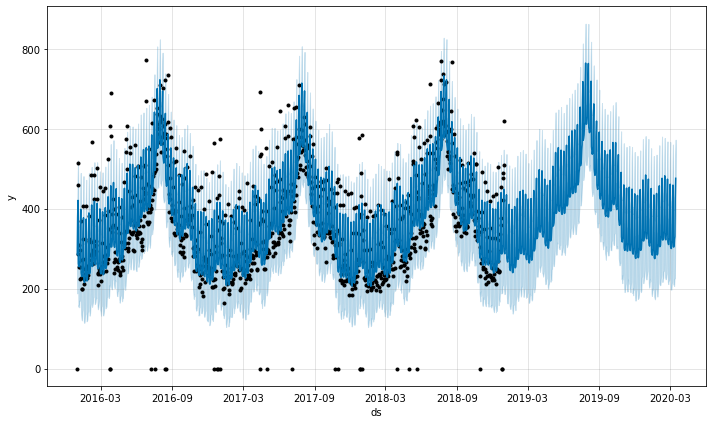

In [354]:
fig1 =model.plot(prediction)

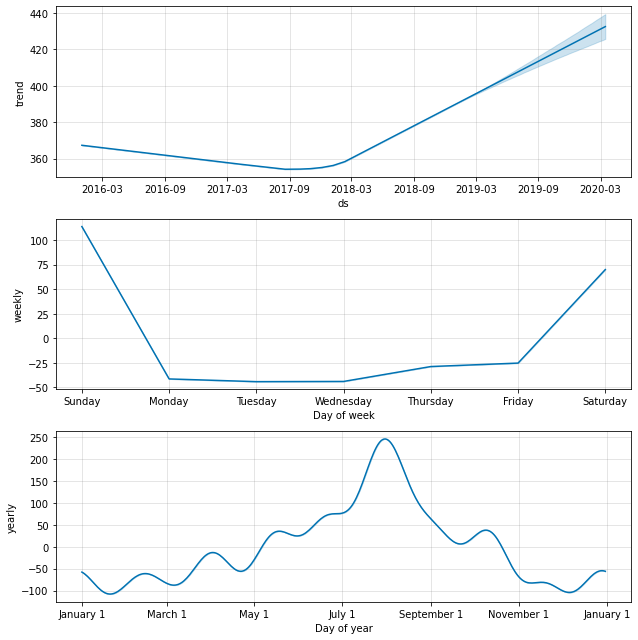

In [373]:
# Plot of the components
fig2 = model.plot_components(prediction)

In [ ]:
# Adding of changepoints
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(prediction)
a = add_changepoints_to_plot(fig.gca(), model, prediction)

In [ ]:
model.changepoints

In [ ]:
#### Seasonal Dependencies

In [ ]:
for article in article_selection:
    data = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    model = Prophet(yearly_seasonality=True,weekly_seasonality=True)
    model.fit(data)
    future = model.make_future_dataframe(periods=440)
    prediction = model.predict(future)
    MAE = (mean_absolute_error(test_new_2[article],
    prediction.loc[(prediction['ds']>= test_new_2.index.min())]['yhat']))
    MAPE= (mean_absolute_percentage_error(test_new_2[article],
    prediction.loc[(prediction['ds']>= test_new_2.index.min())]['yhat']))

In [353]:
#residuals = [validation_fil_3[article][idx] - prediction['yhat'][idx] for idx in validation_fil_3[article].index]

## Holt Winter’s Exponential Smoothing (HWES)